In [1]:
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
from math import sqrt, exp
from statistics import mean

from statsmodels.api import ProbPlot
from statsmodels.graphics import tsaplots
from statsmodels.stats.stattools import jarque_bera as jb
from statsmodels.stats.diagnostic import acorr_ljungbox as lb
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy.stats import kstest, boxcox, gaussian_kde, norm

from pmdarima.arima import ndiffs
from pmdarima.arima import nsdiffs

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from tstoolbox import *

import warnings
warnings.filterwarnings("ignore")

def tsplot (serie, alpha=1):
    plt.plot(serie, alpha=alpha)
    plt.xlabel("Tiempo en meses")
    plt.xlim([serie.index[0], serie.index[-1]])

def ts_split (serie, train_size=0.8):
    train_len  = int(len(serie) * train_size)
    split_date_train = serie.index[0] + relativedelta(months = train_len)
    split_date_test = serie.index[0] + relativedelta(months = train_len+1)
    train = serie[:split_date_train]
    test  = serie[split_date_test:]
    return train, test

def train_test_plot (train, test, leg_position=0):
    plt.plot(train)
    plt.plot(test, alpha=0.6)
    plt.axvspan(test.index[0], test.index[-1], facecolor='grey', alpha=0.1)
    plt.xlabel("Tiempo (meses)")
    plt.xlim([train.index[0], test.index[-1]])
    plt.legend(["Período de modelización", "Período de predicción"],
               loc=leg_position)
    
def forecast_plot (observed, predicted, leg_position=0):
    plt.plot(observed, alpha=0.6)
    plt.plot(predicted, "-.")
    plt.xlabel("Tiempo (meses)")
    plt.xlim([observed.index[0], predicted.index[-1]])
    plt.legend(["Observado", "Predicho"], loc=leg_position)
    
def naive (train, test):
    naive_list = []
    last = train.value[-1]
    
    for i in range(len(test)):
        naive_list.append(last)
        
    naive_forecast = pd.Series(naive_list)
    naive_forecast.index = test.index
    return naive_forecast
        
def snaive (train, test):
    snaive_list = []
    last_seas = list(train.values[-12:])

    for i in range(len(test)): 
        last_seas.append(last_seas[-12])
        snaive_list.append(last_seas[-12])
    
    snaive_forecast = pd.Series(snaive_list)
    snaive_forecast.index = test.index
    return snaive_forecast
    
def stationarity_test (serie):
    adf_test  = adfuller(np.reshape(serie.values, len(serie)))
    kpss_test = kpss(np.reshape(serie.values, len(serie)))
    return adf_test, kpss_test
    
def resid_diag (serie):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    
    ax[0,0].plot(serie)
    ax[0,0].set_xlim(serie.index[0], serie.index[-1])
    ax[0,0].set_title('Residuales estandarizados')
    
    ax[0,1].hist(serie, normed=True, alpha=0.5)
    kde = gaussian_kde(serie)
    xlim = (-1.96*2, 1.96*2)
    x = np.linspace(xlim[0], xlim[1])
    ax[0,1].plot(x, kde(x), label='KDE')
    ax[0,1].plot(x, norm.pdf(x), label='N(0,1)')
    ax[0,1].set_title('Densidad teórica N(0, 1) y estimada')
    
    pp = ProbPlot(serie, dist=norm, fit=True)
    qq = pp.qqplot(ax=ax[1,0], markerfacecolor='cornflowerblue',
                   line="45")
    ax[1,0].set_title('Gráfico QQ')
    
    tsaplots.plot_acf(serie, ax=ax[1, 1], lags=24)
    ax[1,1].set_title('ACF')
    
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    
    return fig, ax

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def iter_forecast(model, input_x, n_input, test):
    yhat_sequence = []
    input_data = [x for x in input_x]
    for j in range(len(test)):
        # prepare the input data
        X = np.array(input_data[-n_input:]).reshape(1, n_input)
        # make a one-step forecast
        yhat = model.predict(X)[0]
        # add to the result
        yhat_sequence.append(yhat)
        # add the prediction to the input
        input_data.append(yhat)
    yhat_ts = pd.Series(yhat_sequence)
    yhat_ts.index = test.index
    return yhat_ts

def tscv_plot (train, test, end):
    
    train_start = train.index[0]
    test_start  = test.index[0]
    test_end    = test.index[-1]
        
    plt.plot(train)
    plt.plot(test)
    plt.axvspan(test_start, test_end, facecolor='grey', alpha=0.1)
    plt.xlabel("Tiempo (meses)")
    plt.xlim([train_start, end])
    plt.legend(["Train", "Validation"], loc="upper center",
               bbox_to_anchor=(1.08, 0.6), ncol=1, frameon = False)

def smape (observed, predicted):
    residual = predicted - observed
    pe_sum = np.abs(residual) / (np.abs(observed) + np.abs(predicted))
    return (200/len(observed))*np.sum(pe_sum)

In [2]:
sns.set(rc = {"figure.figsize":(10,4), "axes.facecolor": "#eeeef4"})
#my_palette = sns.color_palette(sns.diverging_palette(255, 133, l=40, n=4, center="dark"))
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
my_palette = sns.color_palette(flatui)
sns.set_palette(my_palette)

In [4]:
ts_df = pd.read_csv('/Users/ariasrodriguez/Documents/GitHub/Data_Analytics-Big_Data/Task 5.4/Anexos/wolf_river.csv', sep = ';')
ts_df.head(10)

month    value
0  1914-01   55.275
1  1914-02   49.951
2  1914-03   42.617
3  1914-04   26.901
4  1914-05   22.654
5  1914-06   35.793
6  1914-07   66.063
7  1914-08   83.903
8  1914-09  113.636
9  1914-10   60.655

In [3]:
ts_df['index'] = pd.to_datetime(ts_df['month'])
ts_df.set_index('index', inplace = True)
ts_df.drop(["month"], axis = 1, inplace = True) # Serie como pd.DataFrame
ts = ts_df.iloc[:,0] # Serie como pd.Series
np.random.seed(8675309)

value
index              
1914-01-01   55.275
1914-02-01   49.951
1914-03-01   42.617
1914-04-01   26.901
1914-05-01   22.654
1914-06-01   35.793
1914-07-01   66.063
1914-08-01   83.903
1914-09-01  113.636
1914-10-01   60.655

In [31]:
type(ts_df)

pandas.core.frame.DataFrame

In [12]:
type(ts)

pandas.core.series.Series

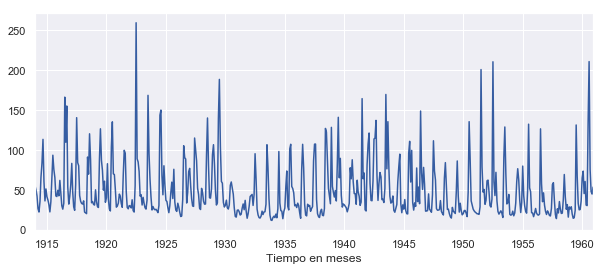

In [6]:
tsplot(ts)
plt.savefig("river.png", dpi = 400)
plt.show()

#### División temporal en período de modelización y período de predicción

In [70]:
train = ts_split(ts)[0] # Período de ajsute de modelos
test  = ts_split(ts)[1]    # Período de generación de predicciones

In [52]:
train

index
1914-01-01     55.275
1914-02-01     49.951
1914-03-01     42.617
1914-04-01     26.901
1914-05-01     22.654
               ...   
1951-04-01     20.388
1951-05-01     19.709
1951-06-01     29.138
1951-07-01    201.021
1951-08-01     79.174
Name: value, Length: 452, dtype: float64

In [53]:
test

index
1951-09-01     47.629
1951-10-01     50.942
1951-11-01     32.310
1951-12-01     37.293
1952-01-01     61.759
               ...   
1960-08-01    211.017
1960-09-01     76.002
1960-10-01     48.394
1960-11-01     45.109
1960-12-01     53.830
Name: value, Length: 112, dtype: float64

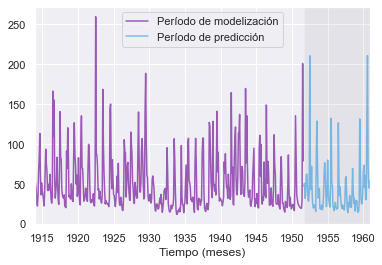

In [54]:
train_test_plot(train, test)
plt.savefig("river_split.png", dpi = 400)
plt.show()

#### Fechas destacables

In [71]:
start_date = train.index[0]
split_date = test.index[0]  # Primera observación a predecir
end_date   = test.index[-1]

#### Preprocesamientos para la serie

In [72]:
boxcox_trans = stats.boxcox(train)
bc_param = boxcox_trans[0]
bc_train = ((train**bc_param)-1)/bc_param

In [75]:
ts_components = seasonal_decompose(train, "add")
seasonal = ts_components.seasonal
deseas = train - seasonal

seasonality_forecast = snaive(seasonal, test)

In [76]:
diff_train = train.diff(1).iloc[1:]

In [77]:
bc_ts_components = seasonal_decompose(bc_train, "add")
bc_seasonal = bc_ts_components.seasonal
bc_deseas = bc_train - bc_seasonal

bc_seasonality_forecast = snaive(bc_seasonal, test)

In [78]:
diff_bc_train = bc_train.diff(1).iloc[1:]

In [79]:
diff_deseas = deseas.diff(1).iloc[1:]

In [80]:
bc_diff_deseas = bc_deseas.diff(1).iloc[1:]

#### Fijación de semilla para reproducibilidad

In [81]:
seed = 1

### Serie temporal original

In [89]:
p = ts_split(ts_df)[0]

In [91]:
lag_df = series_to_supervised(p, n_in=12)
lag_df.head(5)

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  \
index                                                                  
1915-01-01      55.275      49.951      42.617     26.901     22.654   
1915-02-01      49.951      42.617      26.901     22.654     35.793   
1915-03-01      42.617      26.901      22.654     35.793     66.063   
1915-04-01      26.901      22.654      35.793     66.063     83.903   
1915-05-01      22.654      35.793      66.063     83.903    113.636   

            var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
index                                                                          
1915-01-01     35.793     66.063     83.903    113.636     60.655     36.557   
1915-02-01     66.063     83.903    113.636     60.655     36.557     51.537   
1915-03-01     83.903    113.636     60.655     36.557     51.537     41.739   
1915-04-01    113.636     60.655     36.557     51.537     41.739     37.492   
1915-05-01     60.655     36.557     51.537     41.739     37.492     31.998   

            var1(t-1)  var1(t)  
index                           
1915-01-01     51.537   41.739  
1915-02-01     41.739   37.492  
1915-03-01     37.492   31.998  
1915-04-01     31.998   22.823  
1915-05-01     22.823   35.566

#### Definición de X (predictoras) e y (a predecir)

In [92]:
X_train = lag_df.iloc[:,:-1]
y_train = lag_df.iloc[:,-1]

#### Validación cruzada temporal

In [93]:
train3, validation3 = ts_split(lag_df, train_size=0.75)
X_train3 = train3.iloc[:,:-1]
y_train3 = train3.iloc[:,-1]
X_val3 = validation3.iloc[:,:-1]
y_val3 = validation3.iloc[:,-1]

train2, validation2 = ts_split(train3, train_size=0.66)
X_train2 = train2.iloc[:,:-1]
y_train2 = train2.iloc[:,-1]
X_val2 = validation2.iloc[:,:-1]
y_val2 = validation2.iloc[:,-1]

train1, validation1 = ts_split(train2, train_size=0.5)
X_train1 = train1.iloc[:,:-1]
y_train1 = train1.iloc[:,-1]
X_val1 = validation1.iloc[:,:-1]
y_val1 = validation1.iloc[:,-1]

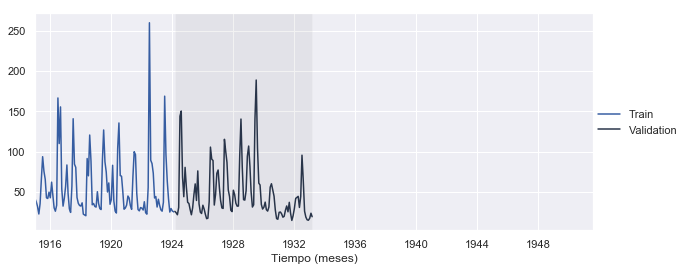

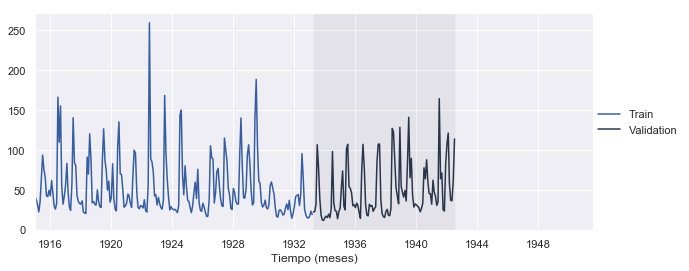

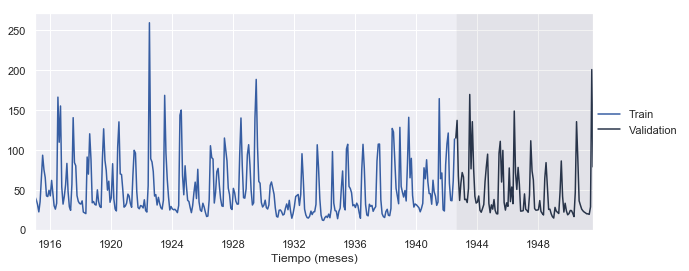

In [21]:
tscv_plot(train1["var1(t)"], validation1["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train2["var1(t)"], validation2["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train3["var1(t)"], validation3["var1(t)"], train.index[-1])
plt.show()

##### K-Nearest Neighbors 

In [94]:
neigb = list(np.arange(2, 41, 1))

In [95]:
best_score, best_knn = float("inf"), None

for k in neigb:    
        knn = KNeighborsRegressor(n_neighbors=k)
        
        knn_model1 = knn.fit(X_train1, y_train1)
        knn_forecast = iter_forecast(knn_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], knn_forecast))
        
        knn_model2 = knn.fit(X_val1, y_val1)
        knn_forecast = iter_forecast(knn_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], knn_forecast))
        
        knn_model3 = knn.fit(X_val2, y_val2)
        knn_forecast = iter_forecast(knn_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], knn_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])        
        if cvrmse < best_score:
            best_score, best_knn = cvrmse, knn.get_params()
        
print('Best KNN: k = %s | CVRMSE = %.3f' % (best_knn['n_neighbors'],
                                            best_score))

Best KNN: k = 12 | CVRMSE = 30.586


In [96]:
knn_hyp = {"k": 12}

In [97]:
knn = KNeighborsRegressor(n_neighbors=knn_hyp["k"])
knn_model = knn.fit(X_train, y_train)
knn_fitted = pd.Series(knn_model.predict(X_train))
knn_fitted
knn_fitted.index = X_train.index
knn_resid = y_train - knn_fitted
knn_resid = (knn_resid - 
             knn_resid.mean()) / knn_resid.std()

knn_jb_test = jb(knn_resid)
knn_lb_test = lb(knn_resid)

knn_forecast = iter_forecast(knn, y_train, 12, test)

AttributeError: 'Rectangle' object has no property 'normed'

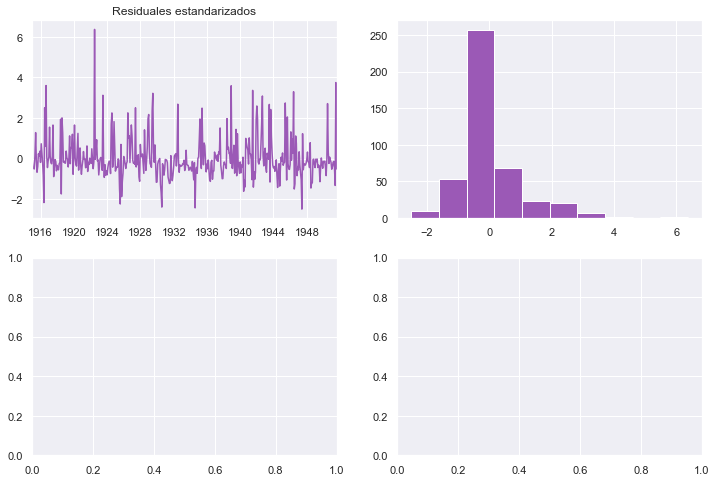

In [115]:
resid_diag(knn_resid)
plt.show()

In [106]:
print("K-Nearest Neighbors")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(knn_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(knn_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(knn_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, knn_forecast))))
print("MAE (test):  " + str(mae(test, knn_forecast)))
print("sMAPE (test):  " + str(smape(test, knn_forecast)))

K-Nearest Neighbors

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 2.903200667052171e-168
Test de Ljung-Box para k =  6 (p-valor): 0.039329353472865085
Test de Ljung-Box para k = 12 (p-valor): 0.07230606434407635

RMSE (test): 25.57542279856696
MAE (test):  16.631637648809523
sMAPE (test):  35.39380649389102


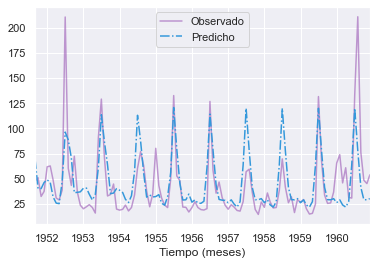

In [107]:
forecast_plot(test, knn_forecast)
plt.show()

##### Regresion tree

In [108]:
depths = list(np.arange(1, 21, 1))

In [109]:
best_score, best_tree = float("inf"), None

for depth in depths:    
        tree = DecisionTreeRegressor(max_depth=depth, random_state=seed)
        
        tree_model1 = tree.fit(X_train1, y_train1)
        tree_forecast = iter_forecast(tree_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], tree_forecast))
        
        tree_model2 = tree.fit(X_val1, y_val1)
        tree_forecast = iter_forecast(tree_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], tree_forecast))
        
        tree_model3 = tree.fit(X_val2, y_val2)
        tree_forecast = iter_forecast(tree_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], tree_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
        if cvrmse < best_score:
            best_score, best_tree = cvrmse, tree.get_params()
        
print('Best Tree: depth: %s | CV RMSE = %.3f' % (best_tree['max_depth'],
                                                 best_score))

Best Tree: depth: 1 | CV RMSE = 34.312


In [110]:
tree_hyp = {"depth": 1}

In [111]:
tree = DecisionTreeRegressor(max_depth=tree_hyp["depth"], random_state=seed)
tree_model = tree.fit(X_train, y_train)
tree_fitted = pd.Series(tree_model.predict(X_train))
tree_fitted
tree_fitted.index = X_train.index
tree_resid = y_train - tree_fitted
tree_resid = (tree_resid - 
              tree_resid.mean()) / tree_resid.std()

tree_jb_test = jb(tree_resid)
tree_lb_test = lb(tree_resid)

tree_forecast = iter_forecast(tree, y_train, 12, test)

AttributeError: 'Rectangle' object has no property 'normed'

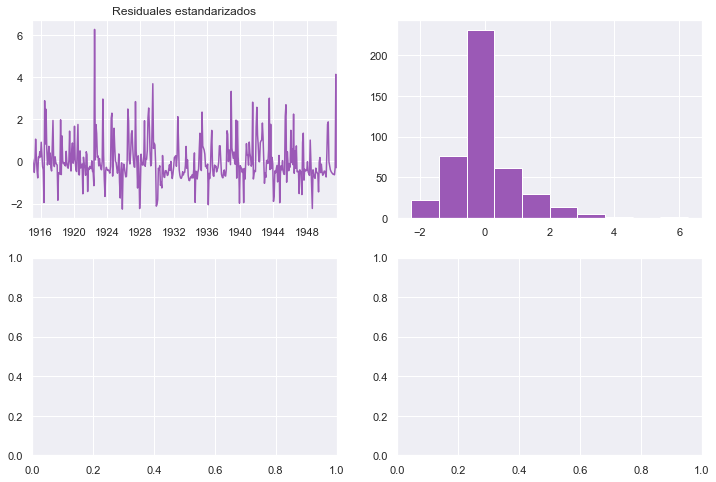

In [112]:
resid_diag(tree_resid)
plt.show()

In [113]:
print("Decision Tree")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(tree_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(tree_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(tree_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, tree_forecast))))
print("MAE (test):  " + str(mae(test, tree_forecast)))
print("sMAPE (test):  " + str(smape(test, tree_forecast)))

Decision Tree

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 2.3423838676505707e-129
Test de Ljung-Box para k =  6 (p-valor): 2.028587146333536e-07
Test de Ljung-Box para k = 12 (p-valor): 8.268260440498816e-06

RMSE (test): 25.83950361433136
MAE (test):  18.321662961679994
sMAPE (test):  40.46374917218229


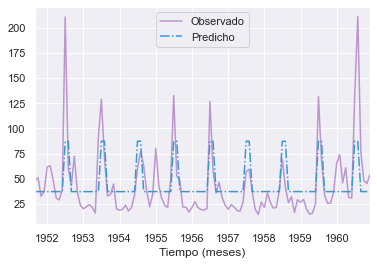

In [114]:
forecast_plot(test, tree_forecast)
plt.show()

##### Random Forest

In [37]:
best_score, best_tree = float("inf"), None

n_estimators = [50, 100, 200, 500]
depths = np.linspace(1, 61, 20)
max_features = [0.8, 1]


for n in n_estimators:
    for depth in depths:
        for features in max_features:
            rf = RandomForestRegressor(n_estimators=n,
                                       max_depth=depth,
                                       max_features=features,
                                       random_state=seed)
        
            rf_model1 = rf.fit(X_train1, y_train1)
            rf_forecast = iter_forecast(rf_model1, y_train1, 12, validation1)
            rmse1 = sqrt(mse(validation1.iloc[:,-1], rf_forecast))
        
            rf_model2 = rf.fit(X_val1, y_val1)
            rf_forecast = iter_forecast(rf_model2, y_val1, 12, validation2)
            rmse2 = sqrt(mse(validation2.iloc[:,-1], rf_forecast))
        
            rf_model3 = rf.fit(X_val2, y_val2)
            rf_forecast = iter_forecast(rf_model3, y_val2, 12, validation3)
            rmse3 = sqrt(mse(validation3.iloc[:,-1], rf_forecast))
        
            cvrmse = mean([rmse1, rmse2, rmse3])        
            if cvrmse < best_score:
                best_score, best_rf = cvrmse, rf.get_params()
        
print('Best RF: n_estimators: %s max_depth: %s max_features : %s | CV RMSE = %.3f' %
      (best_rf['n_estimators'], best_rf['max_depth'],
       best_rf['max_features'], best_score))

Best RF: n_estimators: 50 max_depth: 1.0 max_features : 0.8 | CV RMSE = 32.379


In [38]:
rf_hyp = {"max_depth": 1,
          "n_estimators": 50,
          "max_features": 0.8}

In [39]:
rf = RandomForestRegressor(max_depth=rf_hyp["max_depth"], n_estimators=rf_hyp["n_estimators"],
                           max_features=rf_hyp["max_features"], random_state=seed)

rf_model = rf.fit(X_train, y_train)
rf_fitted = pd.Series(rf_model.predict(X_train))
rf_fitted
rf_fitted.index = X_train.index
rf_resid = y_train - rf_fitted
rf_resid = (rf_resid - rf_resid.mean()) / rf_resid.std()

rf_jb_test = jb(rf_resid)
rf_lb_test = lb(rf_resid)

rf_forecast = iter_forecast(rf, y_train, 12, test)

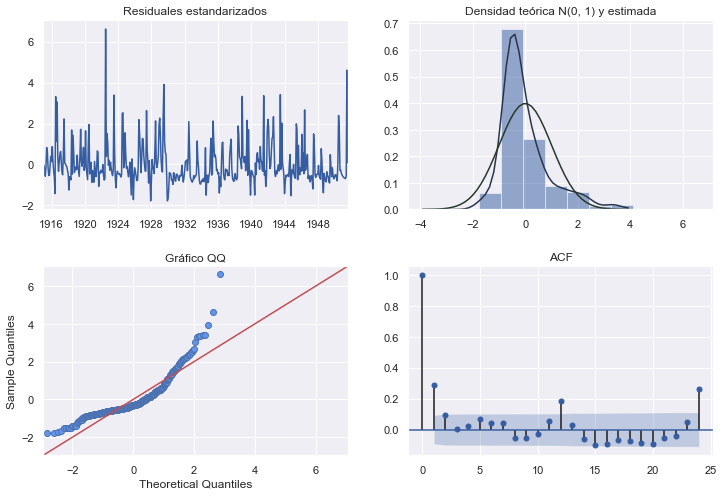

In [40]:
resid_diag(rf_resid)
plt.show()

In [41]:
print("Random Forest")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(rf_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(rf_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " + 
      str(rf_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, rf_forecast))))
print("MAE (test):  " + str(mae(test, rf_forecast)))
print("sMAPE (test):  " + str(smape(test, rf_forecast)))

Random Forest

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 1.7713368672108015e-226
Test de Ljung-Box para k =  6 (p-valor): 1.3674098923847824e-07
Test de Ljung-Box para k = 12 (p-valor): 4.580087633609218e-09

RMSE (test): 27.274163651871557
MAE (test):  18.873514748356094
sMAPE (test):  42.28556263637247


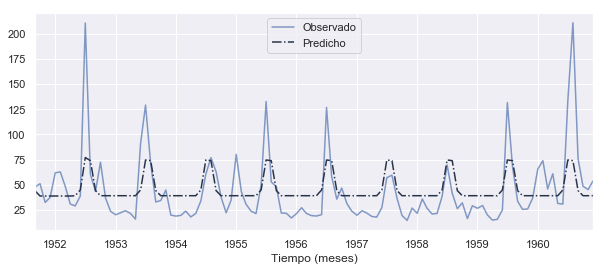

In [42]:
forecast_plot(test, rf_forecast)
plt.show()

##### ElasticNet

In [43]:
best_score, best_tree = float("inf"), None

ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alpha = [0, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]


for rat in ratio:
    for alp in alpha:
        en = ElasticNet(l1_ratio=rat, alpha=alp, random_state=seed)
        
        en_model1 = en.fit(X_train1, y_train1)
        en_forecast = iter_forecast(en_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], en_forecast))
        
        en_model2 = en.fit(X_val1, y_val1)
        en_forecast = iter_forecast(en_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], en_forecast))
        
        en_model3 = en.fit(X_val2, y_val2)
        en_forecast = iter_forecast(en_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], en_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
        if cvrmse < best_score:
            best_score, best_en = cvrmse, en.get_params()
        
print('Best EN: ratio: %s alpha: %s | CV RMSE = %.3f' %
      (best_en['l1_ratio'], best_en['alpha'], best_score))

Best EN: ratio: 0.1 alpha: 100 | CV RMSE = 31.974


In [44]:
en_hyp = {"l1_ratio": 0.1,
          "alpha": 100}

In [45]:
en = ElasticNet(l1_ratio=en_hyp["l1_ratio"], alpha=en_hyp["alpha"],
                random_state=seed)
en_model = en.fit(X_train, y_train)
en_fitted = pd.Series(en_model.predict(X_train))
en_fitted
en_fitted.index = X_train.index
en_resid = y_train - en_fitted
en_resid = (en_resid - en_resid.mean()) / en_resid.std()

en_jb_test = jb(en_resid)
en_lb_test = lb(en_resid)

en_forecast = iter_forecast(en, y_train, 12, test)

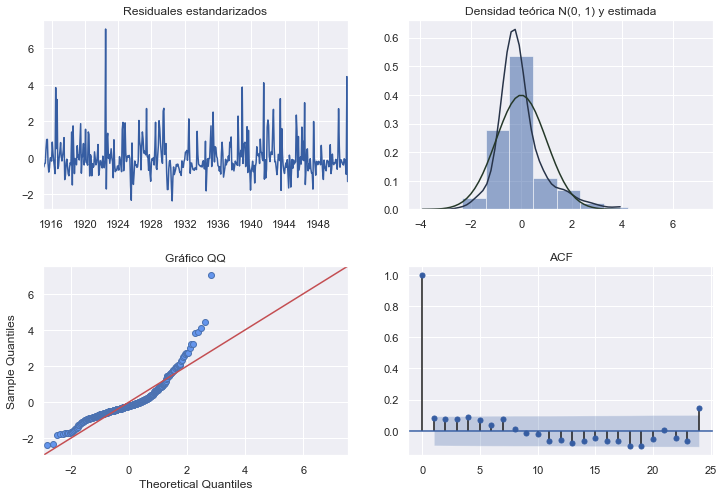

In [46]:
resid_diag(en_resid)
plt.show()

In [47]:
print("ElasticNet")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(en_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(en_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " + 
      str(en_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, en_forecast))))
print("MAE (test):  " + str(mae(test, en_forecast)))
print("sMAPE (test):  " + str(smape(test, en_forecast)))

ElasticNet

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 3.034582288460461e-305
Test de Ljung-Box para k =  6 (p-valor): 0.018580289030905108
Test de Ljung-Box para k = 12 (p-valor): 0.0377027495242834

RMSE (test): 30.11545109033476
MAE (test):  22.0843920027641
sMAPE (test):  48.59639886725879


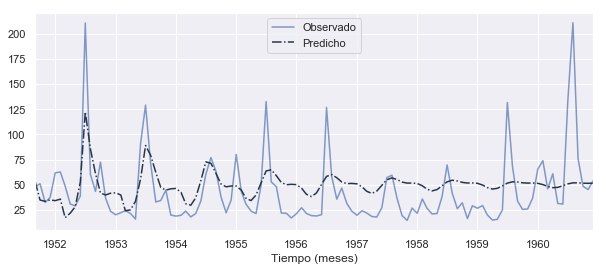

In [48]:
forecast_plot(test, en_forecast)
plt.show()

#### Serie temporal transformada con Box-Cox como estructura de DataFrame

In [49]:
lag_df = series_to_supervised(bc_train, n_in=12)
lag_df.head(5)

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  \
index                                                                  
1915-01-01    2.056547    2.034131    1.997200   1.876680   1.825973   
1915-02-01    2.034131    1.997200    1.876680   1.825973   1.953956   
1915-03-01    1.997200    1.876680    1.825973   1.953956   2.093966   
1915-04-01    1.876680    1.825973    1.953956   2.093966   2.140314   
1915-05-01    1.825973    1.953956    2.093966   2.140314   2.193369   

            var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
index                                                                          
1915-01-01   1.953956   2.093966   2.140314   2.193369   2.076357   1.959344   
1915-02-01   2.093966   2.140314   2.193369   2.076357   1.959344   2.041142   
1915-03-01   2.140314   2.193369   2.076357   1.959344   2.041142   1.992191   
1915-04-01   2.193369   2.076357   1.959344   2.041142   1.992191   1.965730   
1915-05-01   2.076357   1.959344   2.041142   1.992191   1.965730   1.924627   

            var1(t-1)   var1(t)  
index                            
1915-01-01   2.041142  1.992191  
1915-02-01   1.992191  1.965730  
1915-03-01   1.965730  1.924627  
1915-04-01   1.924627  1.828236  
1915-05-01   1.828236  1.952324

#### Definición de X (predictoras) e y (a predecir)

In [50]:
X_train = lag_df.iloc[:,:-1]
y_train = lag_df.iloc[:,-1]

#### Validación cruzada temporal

In [51]:
train3, validation3 = ts_split(lag_df, train_size=0.75)
X_train3 = train3.iloc[:,:-1]
y_train3 = train3.iloc[:,-1]
X_val3 = validation3.iloc[:,:-1]
y_val3 = validation3.iloc[:,-1]

train2, validation2 = ts_split(train3, train_size=0.66)
X_train2 = train2.iloc[:,:-1]
y_train2 = train2.iloc[:,-1]
X_val2 = validation2.iloc[:,:-1]
y_val2 = validation2.iloc[:,-1]

train1, validation1 = ts_split(train2, train_size=0.5)
X_train1 = train1.iloc[:,:-1]
y_train1 = train1.iloc[:,-1]
X_val1 = validation1.iloc[:,:-1]
y_val1 = validation1.iloc[:,-1]

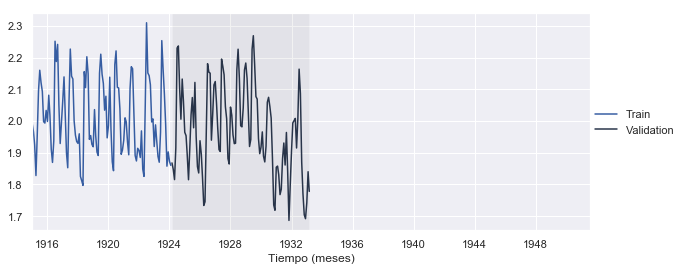

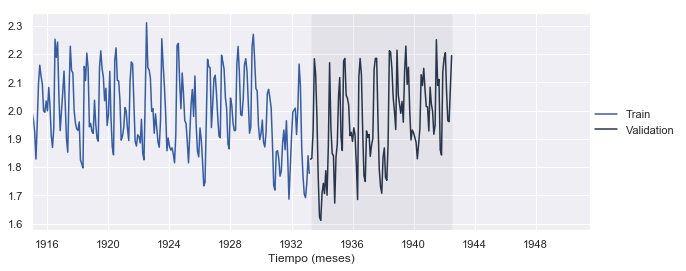

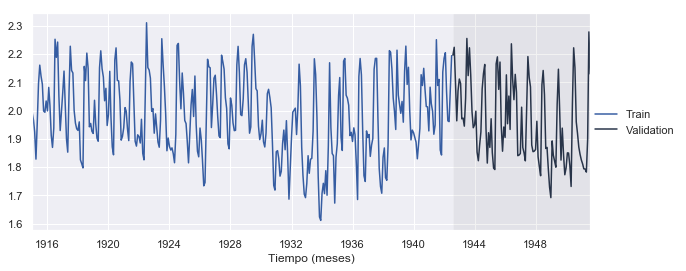

In [52]:
tscv_plot(train1["var1(t)"], validation1["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train2["var1(t)"], validation2["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train3["var1(t)"], validation3["var1(t)"], train.index[-1])
plt.show()

##### K-Nearest Neighbors 

In [53]:
neigb = list(np.arange(2, 41, 1))

In [54]:
best_score, best_knn = float("inf"), None

for k in neigb:    
        knn = KNeighborsRegressor(n_neighbors=k)
        
        knn_model1 = knn.fit(X_train1, y_train1)
        knn_forecast = iter_forecast(knn_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], knn_forecast))
        
        knn_model2 = knn.fit(X_val1, y_val1)
        knn_forecast = iter_forecast(knn_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], knn_forecast))
        
        knn_model3 = knn.fit(X_val2, y_val2)
        knn_forecast = iter_forecast(knn_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], knn_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])        
        if cvrmse < best_score:
            best_score, best_knn = cvrmse, knn.get_params()
        
print('Best KNN %s CVRMSE = %.3f' % (best_knn['n_neighbors'], best_score))

Best KNN 10 CVRMSE = 0.136


In [55]:
knn_hyp = {"k": 10}

In [56]:
knn = KNeighborsRegressor(n_neighbors=knn_hyp["k"])
knn_model = knn.fit(X_train, y_train)
knn_fitted = pd.Series(knn_model.predict(X_train))
knn_fitted
knn_fitted.index = X_train.index
knn_resid = y_train - knn_fitted
knn_resid = (knn_resid - knn_resid.mean()) / knn_resid.std()

knn_jb_test = jb(knn_resid)
knn_lb_test = lb(knn_resid)

knn_forecast = iter_forecast(knn, y_train, 12, test)

In [57]:
knn_box_forecast = (bc_param * knn_forecast + 1) ** (1 / bc_param)

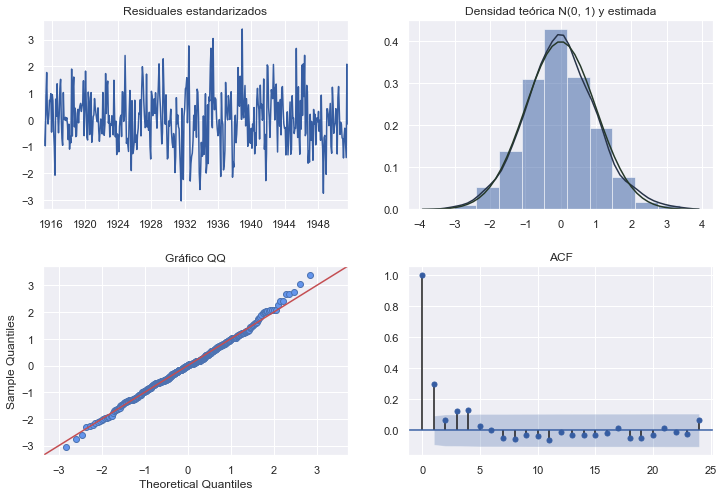

In [58]:
resid_diag(knn_resid)
plt.show()

In [59]:
print("K-Nearest Neighbors")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(knn_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(knn_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " + 
      str(knn_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, knn_box_forecast))))
print("MAE (test):  " + str(mae(test, knn_box_forecast)))
print("sMAPE (test):  " + str(smape(test, knn_box_forecast)))

K-Nearest Neighbors

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 0.14929158900292663
Test de Ljung-Box para k =  6 (p-valor): 6.173994051775582e-10
Test de Ljung-Box para k = 12 (p-valor): 2.2780049116050887e-08

RMSE (test): 23.826827407781153
MAE (test):  16.289851321109712
sMAPE (test):  35.04950163941397


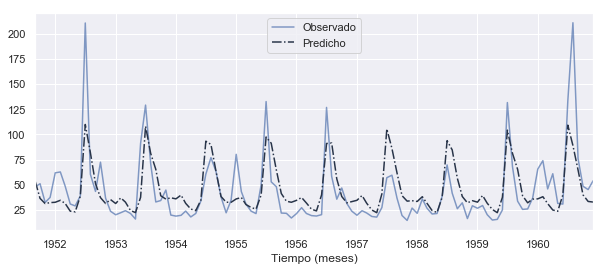

In [60]:
forecast_plot(test, knn_box_forecast)
plt.show()

##### Regresion tree

In [61]:
depths = list(np.arange(1, 21, 1))

In [62]:
best_score, best_tree = float("inf"), None

for depth in depths:    
        tree = DecisionTreeRegressor(max_depth=depth, random_state=seed)
        
        tree_model1 = tree.fit(X_train1, y_train1)
        tree_forecast = iter_forecast(tree_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], tree_forecast))
        
        tree_model2 = tree.fit(X_val1, y_val1)
        tree_forecast = iter_forecast(tree_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], tree_forecast))
        
        tree_model3 = tree.fit(X_val2, y_val2)
        tree_forecast = iter_forecast(tree_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], tree_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])       
        if cvrmse < best_score:
            best_score, best_tree = cvrmse, tree.get_params()
        
print('Best Tree %s CV RMSE = %.3f' % (best_tree['max_depth'], best_score))

Best Tree 5 CV RMSE = 0.152


In [63]:
tree_hyp = {"depth": 5}

In [64]:
tree = DecisionTreeRegressor(max_depth=tree_hyp["depth"],
                             random_state=seed)
tree_model = tree.fit(X_train, y_train)
tree_fitted = pd.Series(tree_model.predict(X_train))
tree_fitted
tree_fitted.index = X_train.index
tree_resid = y_train - tree_fitted
tree_resid = (tree_resid - tree_resid.mean()) / tree_resid.std()

tree_jb_test = jb(tree_resid)
tree_lb_test = lb(tree_resid)

tree_forecast = iter_forecast(tree, y_train, 12, test)

In [65]:
tree_box_forecast = (bc_param * tree_forecast + 1) ** (1 / bc_param)

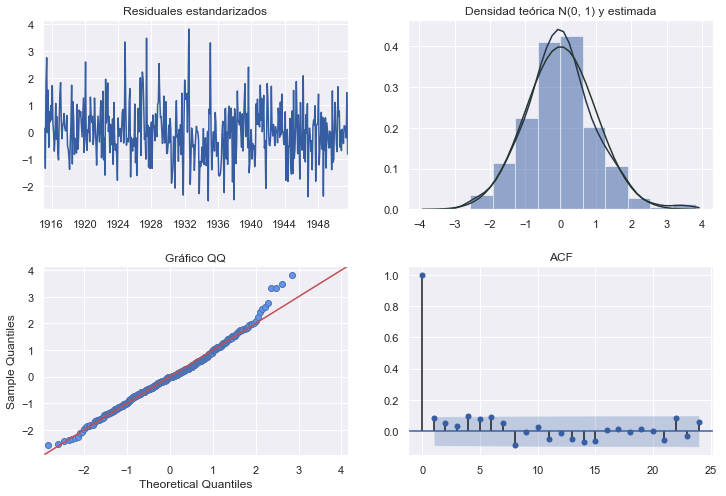

In [66]:
resid_diag(tree_resid)
plt.show()

In [67]:
print("Decision Tree")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(tree_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(tree_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(tree_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, tree_box_forecast))))
print("MAE (test):  " + str(mae(test, tree_box_forecast)))
print("sMAPE (test):  " + str(smape(test, tree_box_forecast)))

Decision Tree

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 1.566066446696135e-05
Test de Ljung-Box para k =  6 (p-valor): 0.020923869379414626
Test de Ljung-Box para k = 12 (p-valor): 0.0421623493635886

RMSE (test): 24.744712241704015
MAE (test):  16.56474204351321
sMAPE (test):  36.708903576558605


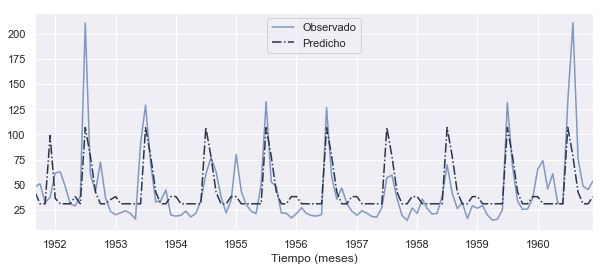

In [68]:
forecast_plot(test, tree_box_forecast)
plt.show()

##### Random Forest

In [69]:
best_score, best_tree = float("inf"), None

n_estimators = [50, 100, 200, 500]
depths = np.linspace(1, 61, 20)
max_features = [0.8, 1]


for n in n_estimators:
    for depth in depths:
        for features in max_features:
            rf = RandomForestRegressor(n_estimators=n,
                                       max_depth=depth,
                                       max_features=features,
                                       random_state=seed)
        
            rf_model1 = rf.fit(X_train1, y_train1)
            rf_forecast = iter_forecast(rf_model1, y_train1, 12, validation1)
            rmse1 = sqrt(mse(validation1.iloc[:,-1], rf_forecast))
        
            rf_model2 = rf.fit(X_val1, y_val1)
            rf_forecast = iter_forecast(rf_model2, y_val1, 12, validation2)
            rmse2 = sqrt(mse(validation2.iloc[:,-1], rf_forecast))
        
            rf_model3 = rf.fit(X_val2, y_val2)
            rf_forecast = iter_forecast(rf_model3, y_val2, 12, validation3)
            rmse3 = sqrt(mse(validation3.iloc[:,-1], rf_forecast))
        
            cvrmse = mean([rmse1, rmse2, rmse3])        
            if cvrmse < best_score:
                best_score, best_rf = cvrmse, rf.get_params()
        
print('Best RF: n_estimators: %s max_depth: %s max_features :%s | CV RMSE = %.3f' %
      (best_rf['n_estimators'], best_rf['max_depth'], best_rf['max_features'], best_score))

Best RF: n_estimators: 50 max_depth: 7.315789473684211 max_features :0.8 | CV RMSE = 0.140


In [70]:
rf_hyp = {"max_depth": 7.32,
          "n_estimators": 50,
          "max_features": 0.8}

In [71]:
rf = RandomForestRegressor(max_depth=rf_hyp["max_depth"],
                           n_estimators=rf_hyp["n_estimators"], 
                           max_features=rf_hyp["max_features"],
                           random_state=seed)

rf_model = rf.fit(X_train, y_train)
rf_fitted = pd.Series(rf_model.predict(X_train))
rf_fitted
rf_fitted.index = X_train.index
rf_resid = y_train - rf_fitted
rf_resid = (rf_resid - rf_resid.mean()) / rf_resid.std()

rf_jb_test = jb(rf_resid)
rf_lb_test = lb(rf_resid)

rf_forecast = iter_forecast(rf, y_train, 12, test)

In [72]:
rf_box_forecast = (bc_param * rf_forecast + 1) ** (1 / bc_param)

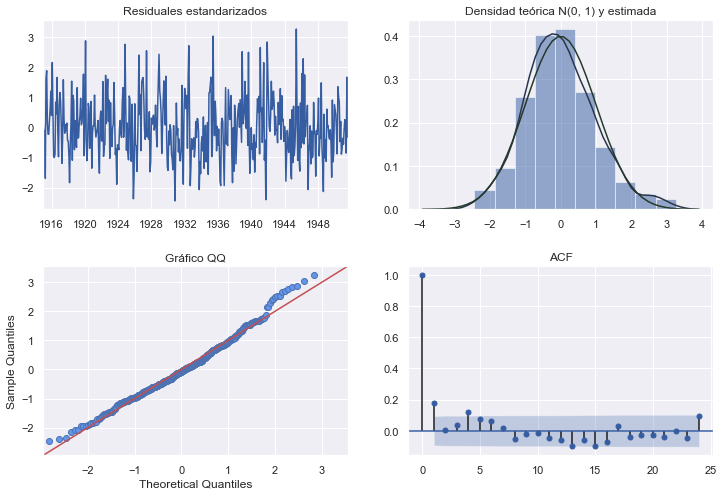

In [73]:
resid_diag(rf_resid)
plt.show()

In [74]:
print("Random Forest")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(rf_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(rf_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " + 
      str(rf_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, rf_box_forecast))))
print("MAE (test):  " + str(mae(test, rf_box_forecast)))
print("sMAPE (test):  " + str(smape(test, rf_box_forecast)))

Random Forest

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 0.0009343986727170103
Test de Ljung-Box para k =  6 (p-valor): 0.0007964689182289883
Test de Ljung-Box para k = 12 (p-valor): 0.0016563699647625693

RMSE (test): 30.496564708279912
MAE (test):  17.28236557049287
sMAPE (test):  37.02239483180497


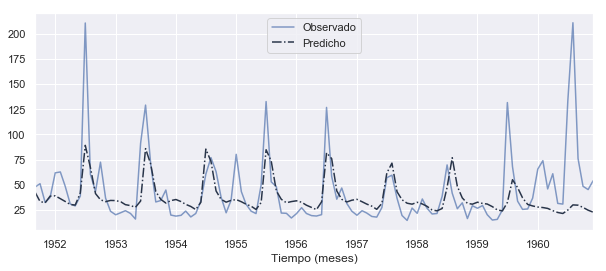

In [75]:
forecast_plot(test, rf_box_forecast)
plt.show()

##### ElasticNet

In [76]:
best_score, best_tree = float("inf"), None

ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alpha = [0, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]


for rat in ratio:
    for alp in alpha:
        en = ElasticNet(l1_ratio=rat, alpha=alp, random_state=seed)
        
        en_model1 = en.fit(X_train1, y_train1)
        en_forecast = iter_forecast(en_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], en_forecast))
        
        en_model2 = en.fit(X_val1, y_val1)
        en_forecast = iter_forecast(en_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], en_forecast))
        
        en_model3 = en.fit(X_val2, y_val2)
        en_forecast = iter_forecast(en_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], en_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
        if cvrmse < best_score:
            best_score, best_en = cvrmse, en.get_params()
        
print('Best EN: ratio: %s alpha: %s | CV RMSE = %.3f' %
      (best_en['l1_ratio'], best_en['alpha'], best_score))

Best EN: ratio: 0.1 alpha: 0 | CV RMSE = 0.140


In [77]:
en_hyp = {"l1_ratio": 0.1,
          "alpha": 0}

In [78]:
en = ElasticNet(l1_ratio=en_hyp["l1_ratio"], alpha=en_hyp["alpha"],
                random_state=seed)
en_model = en.fit(X_train, y_train)
en_fitted = pd.Series(en_model.predict(X_train))
en_fitted
en_fitted.index = X_train.index
en_resid = y_train - en_fitted
en_resid = (en_resid - en_resid.mean()) / en_resid.std()

en_jb_test = jb(en_resid)
en_lb_test = lb(en_resid)

en_forecast = iter_forecast(en, y_train, 12, test)

In [79]:
en_box_forecast = (bc_param * en_forecast + 1) ** (1 / bc_param)

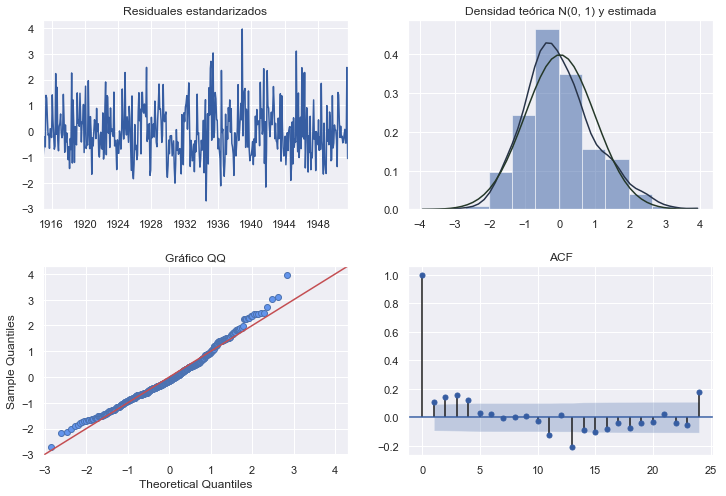

In [80]:
resid_diag(en_resid)
plt.show()

In [81]:
print("ElasticNet")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(en_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(en_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(en_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, en_box_forecast))))
print("MAE (test):  " + str(mae(test, en_box_forecast)))
print("sMAPE (test):  " + str(smape(test, en_box_forecast)))

ElasticNet

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 6.76771127119615e-07
Test de Ljung-Box para k =  6 (p-valor): 4.748066502114843e-05
Test de Ljung-Box para k = 12 (p-valor): 1.0413255691897458e-07

RMSE (test): 33.682465160124686
MAE (test):  20.119056207537295
sMAPE (test):  42.9938082467703


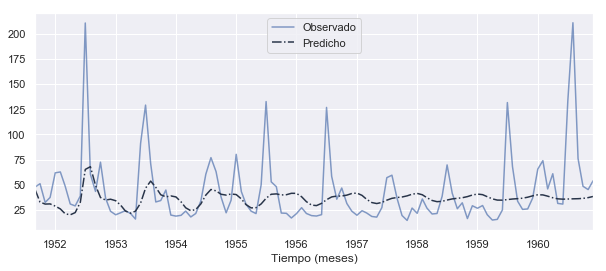

In [82]:
forecast_plot(test, en_box_forecast)
plt.show()

#### Serie temporal desestacionalizada como estructura de DataFrame

In [83]:
lag_df = series_to_supervised(deseas, n_in=12)
lag_df.head(5)

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  \
index                                                                  
1915-01-01   68.056741   55.487990   59.745262  49.642875  47.097132   
1915-02-01   55.487990   59.745262   49.642875  47.097132  19.921335   
1915-03-01   59.745262   49.642875   47.097132  19.921335   2.252072   
1915-04-01   49.642875   47.097132   19.921335   2.252072  56.538266   
1915-05-01   47.097132   19.921335    2.252072  56.538266  96.012723   

            var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
index                                                                          
1915-01-01  19.921335   2.252072  56.538266  96.012723  70.726177  55.973661   
1915-02-01   2.252072  56.538266  96.012723  70.726177  55.973661  64.087769   
1915-03-01  56.538266  96.012723  70.726177  55.973661  64.087769  54.520741   
1915-04-01  96.012723  70.726177  55.973661  64.087769  54.520741  43.028990   
1915-05-01  70.726177  55.973661  64.087769  54.520741  43.028990  49.126262   

            var1(t-1)    var1(t)  
index                             
1915-01-01  64.087769  54.520741  
1915-02-01  54.520741  43.028990  
1915-03-01  43.028990  49.126262  
1915-04-01  49.126262  45.564875  
1915-05-01  45.564875  60.009132

#### Definición de X (predictoras) e y (a predecir)

In [84]:
X_train = lag_df.iloc[:,:-1]
y_train = lag_df.iloc[:,-1]

#### Validación cruzada temporal

In [85]:
train3, validation3 = ts_split(lag_df, train_size=0.75)
X_train3 = train3.iloc[:,:-1]
y_train3 = train3.iloc[:,-1]
X_val3 = validation3.iloc[:,:-1]
y_val3 = validation3.iloc[:,-1]

train2, validation2 = ts_split(train3, train_size=0.66)
X_train2 = train2.iloc[:,:-1]
y_train2 = train2.iloc[:,-1]
X_val2 = validation2.iloc[:,:-1]
y_val2 = validation2.iloc[:,-1]

train1, validation1 = ts_split(train2, train_size=0.5)
X_train1 = train1.iloc[:,:-1]
y_train1 = train1.iloc[:,-1]
X_val1 = validation1.iloc[:,:-1]
y_val1 = validation1.iloc[:,-1]

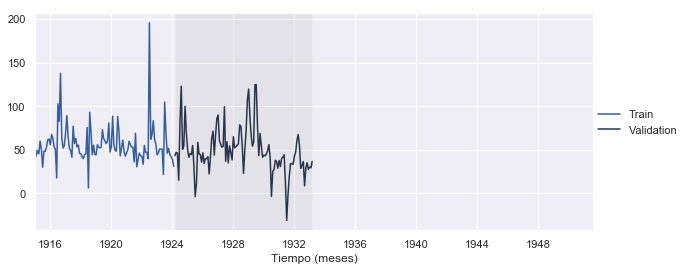

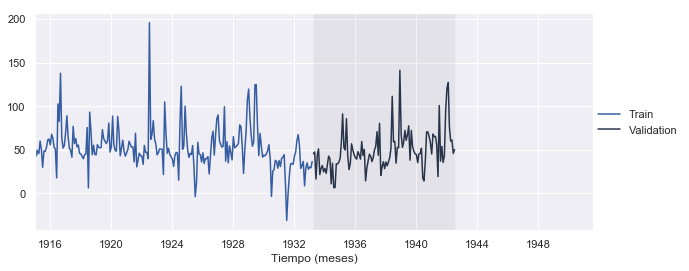

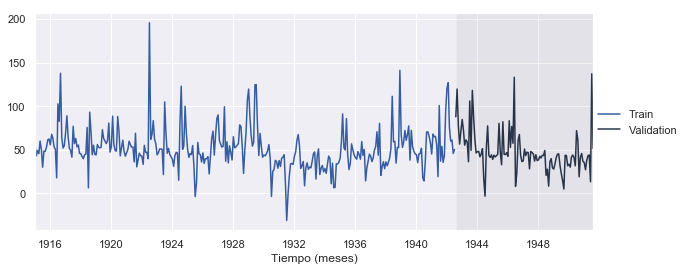

In [86]:
tscv_plot(train1["var1(t)"], validation1["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train2["var1(t)"], validation2["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train3["var1(t)"], validation3["var1(t)"], train.index[-1])
plt.show()

##### K-Nearest Neighbors 

In [87]:
neigb = list(np.arange(2, 41, 1))

In [88]:
best_score, best_knn = float("inf"), None

for k in neigb:    
        knn = KNeighborsRegressor(n_neighbors=k)
        
        knn_model1 = knn.fit(X_train1, y_train1)
        knn_forecast = iter_forecast(knn_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], knn_forecast))
        
        knn_model2 = knn.fit(X_val1, y_val1)
        knn_forecast = iter_forecast(knn_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], knn_forecast))
        
        knn_model3 = knn.fit(X_val2, y_val2)
        knn_forecast = iter_forecast(knn_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], knn_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])        
        if cvrmse < best_score:
            best_score, best_knn = cvrmse, knn.get_params()
        
print('Best KNN %s CVRMSE = %.3f' % (best_knn['n_neighbors'], best_score))

Best KNN 10 CVRMSE = 24.538


In [ ]:
knn_hyp = {"k": 10}

In [89]:
knn = KNeighborsRegressor(n_neighbors=knn_hyp["k"])
knn_model = knn.fit(X_train, y_train)
knn_fitted = pd.Series(knn_model.predict(X_train))
knn_fitted
knn_fitted.index = X_train.index
knn_resid = y_train - knn_fitted
knn_resid = (knn_resid - knn_resid.mean()) / knn_resid.std()

knn_jb_test = jb(knn_resid)
knn_lb_test = lb(knn_resid)

knn_forecast = iter_forecast(knn, y_train, 12, test)

In [90]:
knn_seas_forecast = knn_forecast + seasonality_forecast

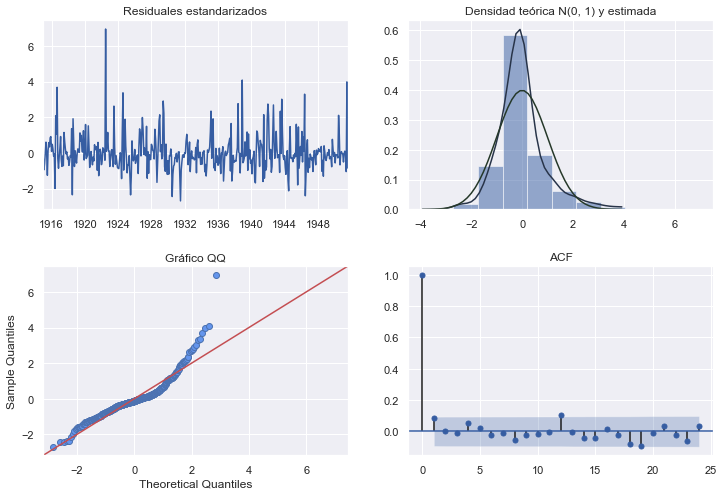

In [91]:
resid_diag(knn_resid)
plt.show()

In [92]:
print("K-Nearest Neighbors")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(knn_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(knn_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " + 
      str(knn_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, knn_seas_forecast))))
print("MAE (test):  " + str(mae(test, knn_seas_forecast)))
print("sMAPE (test):  " + str(smape(test, knn_seas_forecast)))

K-Nearest Neighbors

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 3.221140212318335e-238
Test de Ljung-Box para k =  6 (p-valor): 0.6861542427252421
Test de Ljung-Box para k = 12 (p-valor): 0.5852275392995411

RMSE (test): 35.73070318812319
MAE (test):  23.860184319978462
sMAPE (test):  52.04783996158255


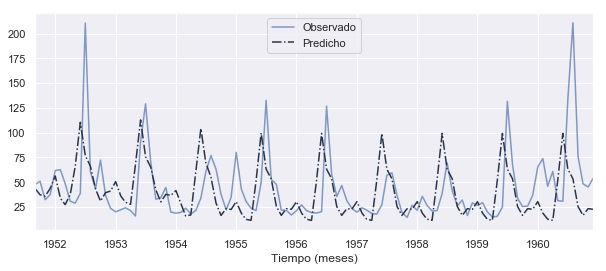

In [93]:
forecast_plot(test, knn_seas_forecast)
plt.show()

##### Regresion tree

In [94]:
depths = list(np.arange(1, 21, 1))

In [95]:
best_score, best_tree = float("inf"), None

for depth in depths:    
        tree = DecisionTreeRegressor(max_depth=depth, random_state=seed)
        
        tree_model1 = tree.fit(X_train1, y_train1)
        tree_forecast = iter_forecast(tree_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], tree_forecast))
        
        tree_model2 = tree.fit(X_val1, y_val1)
        tree_forecast = iter_forecast(tree_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], tree_forecast))
        
        tree_model3 = tree.fit(X_val2, y_val2)
        tree_forecast = iter_forecast(tree_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], tree_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
           
        if cvrmse < best_score:
            best_score, best_tree = cvrmse, tree.get_params()
        
print('Best Tree %s CV RMSE = %.3f' % (best_tree['max_depth'], best_score))

Best Tree 3 CV RMSE = 24.941


In [96]:
tree_hyp = {"depth": 3}

In [97]:
tree = DecisionTreeRegressor(max_depth=tree_hyp["depth"], 
                             random_state=seed)
tree_model = tree.fit(X_train, y_train)
tree_fitted = pd.Series(tree_model.predict(X_train))
tree_fitted
tree_fitted.index = X_train.index
tree_resid = y_train - tree_fitted
tree_resid = (tree_resid - tree_resid.mean()) / tree_resid.std()

tree_jb_test = jb(tree_resid)
tree_lb_test = lb(tree_resid)

tree_forecast = iter_forecast(tree, y_train, 12, test)

In [98]:
tree_seas_forecast = tree_forecast + seasonality_forecast

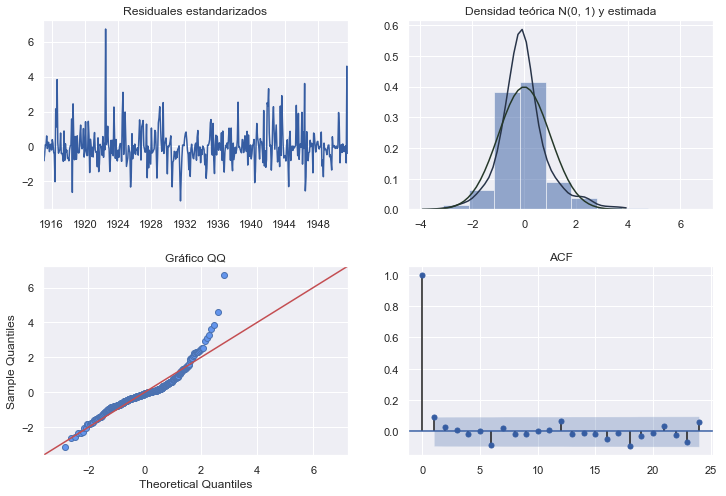

In [99]:
resid_diag(tree_resid)
plt.show()

In [100]:
print("Decision Tree")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(tree_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(tree_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(tree_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, tree_seas_forecast))))
print("MAE (test):  " + str(mae(test, tree_seas_forecast)))
print("sMAPE (test):  " + str(smape(test, tree_seas_forecast)))

Decision Tree

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 2.3249335220687302e-200
Test de Ljung-Box para k =  6 (p-valor): 0.32816725368366206
Test de Ljung-Box para k = 12 (p-valor): 0.648859080395447

RMSE (test): 35.32047965264542
MAE (test):  23.998700669257506
sMAPE (test):  54.28693445110659


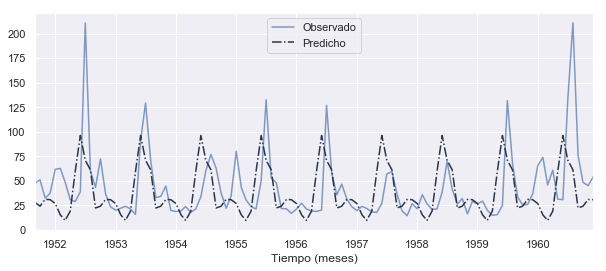

In [101]:
forecast_plot(test, tree_seas_forecast)
plt.show()

##### Random Forest

In [102]:
best_score, best_tree = float("inf"), None

n_estimators = [50, 100, 200, 500]
depths = np.linspace(1, 61, 20)
max_features = [0.8, 1]


for n in n_estimators:
    for depth in depths:
        for features in max_features:
            rf = RandomForestRegressor(n_estimators=n,
                                       max_depth=depth,
                                       max_features=features,
                                       random_state=seed)
        
            rf_model1 = rf.fit(X_train1, y_train1)
            rf_forecast = iter_forecast(rf_model1, y_train1, 12, validation1)
            rmse1 = sqrt(mse(validation1.iloc[:,-1], rf_forecast))
        
            rf_model2 = rf.fit(X_val1, y_val1)
            rf_forecast = iter_forecast(rf_model2, y_val1, 12, validation2)
            rmse2 = sqrt(mse(validation2.iloc[:,-1], rf_forecast))
        
            rf_model3 = rf.fit(X_val2, y_val2)
            rf_forecast = iter_forecast(rf_model3, y_val2, 12, validation3)
            rmse3 = sqrt(mse(validation3.iloc[:,-1], rf_forecast))
        
            cvrmse = mean([rmse1, rmse2, rmse3])        
            if cvrmse < best_score:
                best_score, best_rf = cvrmse, rf.get_params()
        
print('Best RF: n_estimators: %s max_depth: %s max_features :%s | CV RMSE = %.3f' 
      % (best_rf['n_estimators'], best_rf['max_depth'], best_rf['max_features'], best_score))

Best RF: n_estimators: 50 max_depth: 1.0 max_features :1 | CV RMSE = 24.151


In [103]:
rf_hyp = {"max_depth": 1,
          "n_estimators": 50,
          "max_features": 1}

In [104]:
rf = RandomForestRegressor(max_depth=rf_hyp["max_depth"],
                           n_estimators=rf_hyp["n_estimators"],
                           max_features=rf_hyp["max_features"])

rf_model = rf.fit(X_train, y_train)
rf_fitted = pd.Series(rf_model.predict(X_train))
rf_fitted
rf_fitted.index = X_train.index
rf_resid = y_train - rf_fitted
rf_resid = (rf_resid - rf_resid.mean()) / rf_resid.std()

rf_jb_test = jb(rf_resid)
rf_lb_test = lb(rf_resid)

rf_forecast = iter_forecast(rf, y_train, 12, test)

In [105]:
rf_seas_forecast = rf_forecast + seasonality_forecast

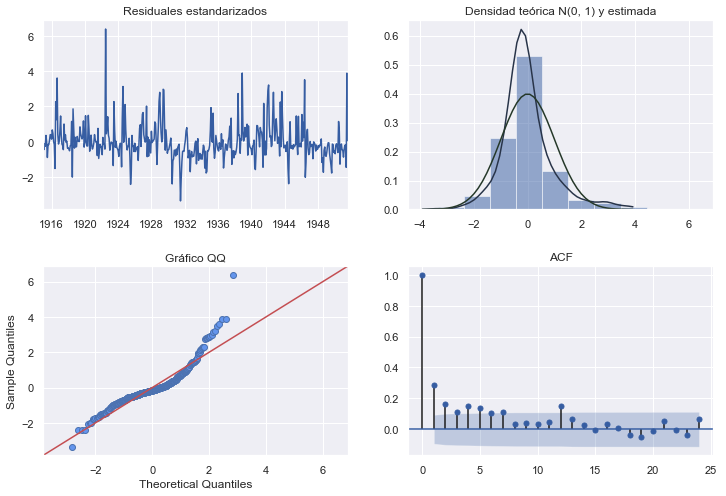

In [106]:
resid_diag(rf_resid)
plt.show()

In [107]:
print("Random Forest")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(rf_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(rf_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(rf_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, rf_seas_forecast))))
print("MAE (test):  " + str(mae(test, rf_seas_forecast)))
print("sMAPE (test):  " + str(smape(test, rf_seas_forecast)))

Random Forest

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 1.3404599347819535e-167
Test de Ljung-Box para k =  6 (p-valor): 3.8209202885056384e-15
Test de Ljung-Box para k = 12 (p-valor): 3.08333506870211e-15

RMSE (test): 37.221632138684946
MAE (test):  26.05070483344991
sMAPE (test):  50.40460863038776


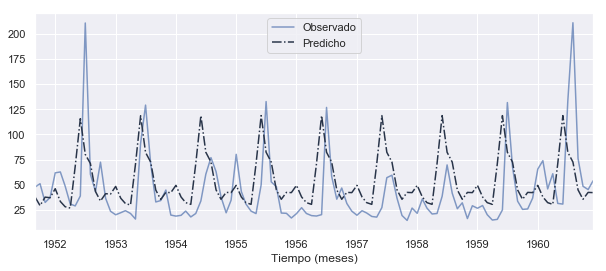

In [108]:
forecast_plot(test, rf_seas_forecast)
plt.show()

##### ElasticNet

In [109]:
best_score, best_tree = float("inf"), None

ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alpha = [0, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]


for rat in ratio:
    for alp in alpha:
        en = ElasticNet(l1_ratio=rat, alpha=alp, random_state=seed)
        
        en_model1 = en.fit(X_train1, y_train1)
        en_forecast = iter_forecast(en_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], en_forecast))
        
        en_model2 = en.fit(X_val1, y_val1)
        en_forecast = iter_forecast(en_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], en_forecast))
        
        en_model3 = en.fit(X_val2, y_val2)
        en_forecast = iter_forecast(en_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], en_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
        if cvrmse < best_score:
            best_score, best_en = cvrmse, en.get_params()
        
print('Best EN: ratio: %s alpha: %s | CV RMSE = %.3f' %
      (best_en['l1_ratio'], best_en['alpha'], best_score))

Best EN: ratio: 0.7 alpha: 50 | CV RMSE = 24.458


In [110]:
en_hyp = {"l1_ratio": 0.7,
          "alpha": 50}

In [111]:
en = ElasticNet(l1_ratio=en_hyp["l1_ratio"], alpha=en_hyp["alpha"], 
                random_state=seed)
en_model = en.fit(X_train, y_train)
en_fitted = pd.Series(en_model.predict(X_train))
en_fitted
en_fitted.index = X_train.index
en_resid = y_train - en_fitted
en_resid = (en_resid - en_resid.mean()) / en_resid.std()

en_jb_test = jb(en_resid)
en_lb_test = lb(en_resid)

en_forecast = iter_forecast(en, y_train, 12, test)

In [112]:
en_seas_forecast = en_forecast + seasonality_forecast

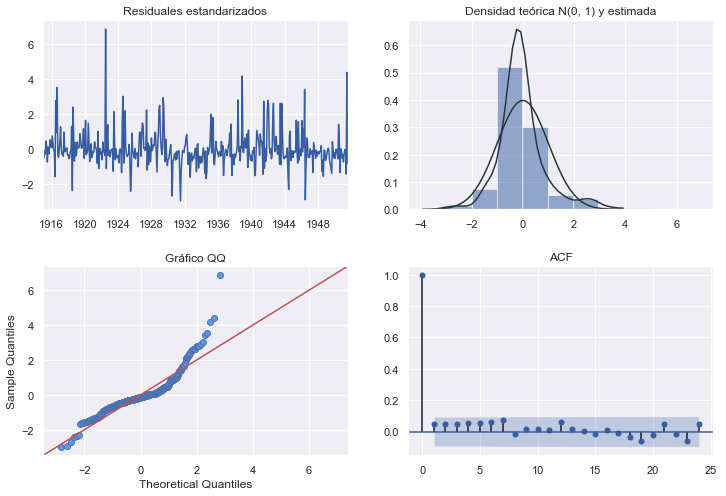

In [113]:
resid_diag(en_resid)
plt.show()

In [114]:
print("ElasticNet")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(en_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(en_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " + 
      str(en_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, en_seas_forecast))))
print("MAE (test):  " + str(mae(test, en_seas_forecast)))
print("sMAPE (test):  " + str(smape(test, en_seas_forecast)))

ElasticNet

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 1.8221992633454572e-265
Test de Ljung-Box para k =  6 (p-valor): 0.2116590961603848
Test de Ljung-Box para k = 12 (p-valor): 0.5484740779269146

RMSE (test): 35.879726444295535
MAE (test):  24.27506662692949
sMAPE (test):  47.12662561864641


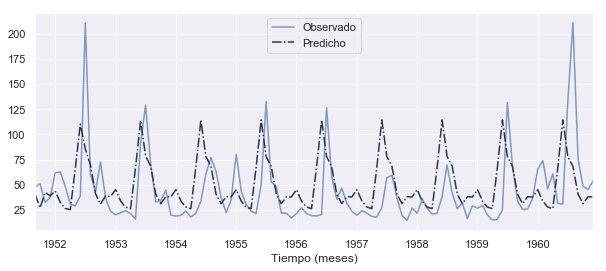

In [115]:
forecast_plot(test, en_seas_forecast)
plt.show()

#### Serie temporal diferenciada como estructura de DataFrame

In [116]:
lag_df = series_to_supervised(diff_train, n_in=12)
lag_df.head(5)

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  \
index                                                                  
1915-02-01      -5.324      -7.334     -15.716     -4.247     13.139   
1915-03-01      -7.334     -15.716      -4.247     13.139     30.270   
1915-04-01     -15.716      -4.247      13.139     30.270     17.840   
1915-05-01      -4.247      13.139      30.270     17.840     29.733   
1915-06-01      13.139      30.270      17.840     29.733    -52.981   

            var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
index                                                                          
1915-02-01     30.270     17.840     29.733    -52.981    -24.098     14.980   
1915-03-01     17.840     29.733    -52.981    -24.098     14.980     -9.798   
1915-04-01     29.733    -52.981    -24.098     14.980     -9.798     -4.247   
1915-05-01    -52.981    -24.098     14.980     -9.798     -4.247     -5.494   
1915-06-01    -24.098     14.980     -9.798     -4.247     -5.494     -9.175   

            var1(t-1)  var1(t)  
index                           
1915-02-01     -9.798   -4.247  
1915-03-01     -4.247   -5.494  
1915-04-01     -5.494   -9.175  
1915-05-01     -9.175   12.743  
1915-06-01     12.743   30.724

#### Definición de X (predictoras) e y (a predecir)

In [117]:
X_train = lag_df.iloc[:,:-1]
y_train = lag_df.iloc[:,-1]

#### Validación cruzada temporal

In [118]:
train3, validation3 = ts_split(lag_df, train_size=0.75)
X_train3 = train3.iloc[:,:-1]
y_train3 = train3.iloc[:,-1]
X_val3 = validation3.iloc[:,:-1]
y_val3 = validation3.iloc[:,-1]

train2, validation2 = ts_split(train3, train_size=0.66)
X_train2 = train2.iloc[:,:-1]
y_train2 = train2.iloc[:,-1]
X_val2 = validation2.iloc[:,:-1]
y_val2 = validation2.iloc[:,-1]

train1, validation1 = ts_split(train2, train_size=0.5)
X_train1 = train1.iloc[:,:-1]
y_train1 = train1.iloc[:,-1]
X_val1 = validation1.iloc[:,:-1]
y_val1 = validation1.iloc[:,-1]

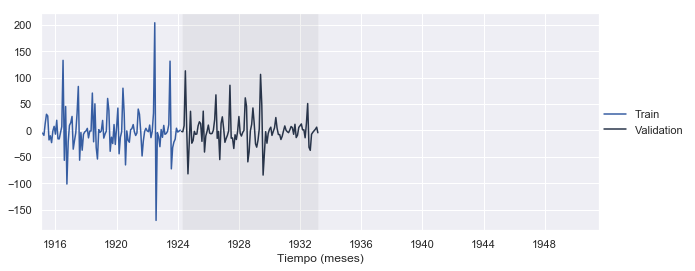

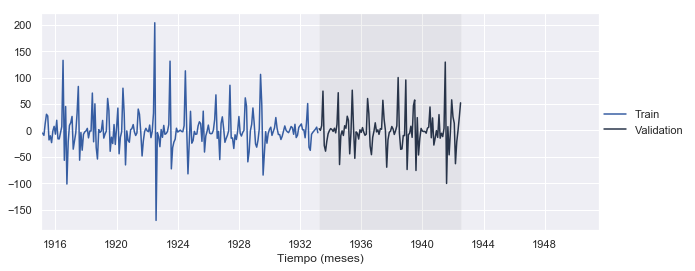

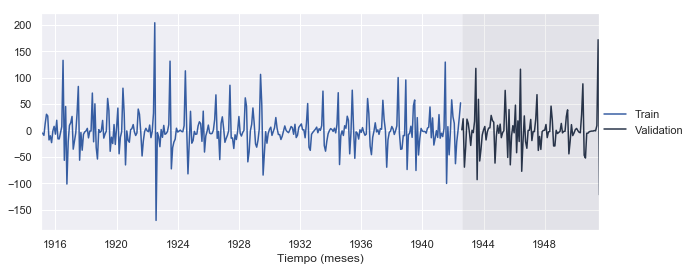

In [119]:
tscv_plot(train1["var1(t)"], validation1["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train2["var1(t)"], validation2["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train3["var1(t)"], validation3["var1(t)"], train.index[-1])
plt.show()

##### K-Nearest Neighbors 

In [120]:
neigb = list(np.arange(2, 41, 1))

In [121]:
best_score, best_knn = float("inf"), None

for k in neigb:    
        knn = KNeighborsRegressor(n_neighbors=k)
        
        knn_model1 = knn.fit(X_train1, y_train1)
        knn_forecast = iter_forecast(knn_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], knn_forecast))
        
        knn_model2 = knn.fit(X_val1, y_val1)
        knn_forecast = iter_forecast(knn_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], knn_forecast))
        
        knn_model3 = knn.fit(X_val2, y_val2)
        knn_forecast = iter_forecast(knn_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], knn_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])                
        if cvrmse < best_score:
            best_score, best_knn = cvrmse, knn.get_params()
        
print('Best KNN %s CVRMSE = %.3f' % (best_knn['n_neighbors'], best_score))

Best KNN 8 CVRMSE = 33.097


In [123]:
knn_hyp = {"k": 8}

In [124]:
knn = KNeighborsRegressor(n_neighbors=knn_hyp["k"])
knn_model = knn.fit(X_train, y_train)
knn_fitted = pd.Series(knn_model.predict(X_train))
knn_fitted
knn_fitted.index = X_train.index
knn_resid = y_train - knn_fitted
knn_resid = (knn_resid - knn_resid.mean()) / knn_resid.std()

knn_jb_test = jb(knn_resid)
knn_lb_test = lb(knn_resid)

knn_forecast = iter_forecast(knn, y_train, 12, test)

In [125]:
knn_undiff_forecast = []
last_obser = train.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + knn_forecast[i]
    knn_undiff_forecast.append(yhat)
    last_obser = yhat
    
knn_undiff_forecast = pd.Series(knn_undiff_forecast)
knn_undiff_forecast.index = test.index

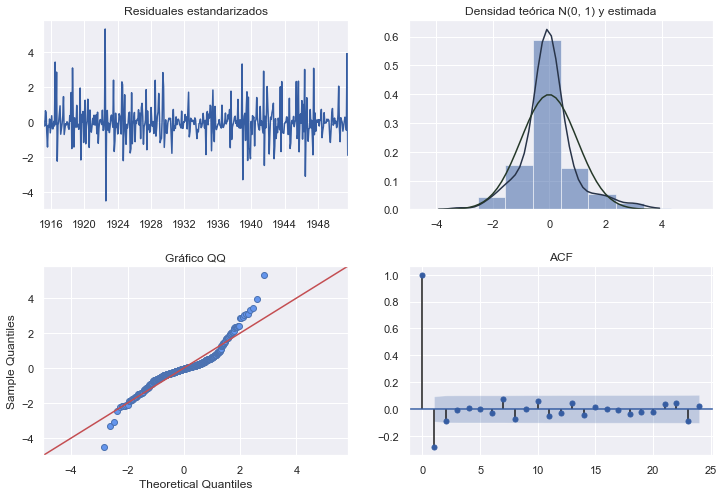

In [126]:
resid_diag(knn_resid)
plt.show()

In [127]:
print("K-Nearest Neighbors")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(knn_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(knn_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(knn_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, knn_undiff_forecast))))
print("MAE (test):  " + str(mae(test, knn_undiff_forecast)))
print("sMAPE (test):  " + str(smape(test, knn_undiff_forecast)))

K-Nearest Neighbors

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 1.917901228467001e-79
Test de Ljung-Box para k =  6 (p-valor): 5.776945665723931e-07
Test de Ljung-Box para k = 12 (p-valor): 5.455386637939246e-06

RMSE (test): 177.22695016002845
MAE (test):  153.15659709821418
sMAPE (test):  121.110202320245


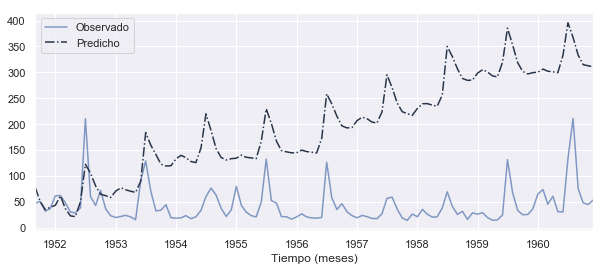

In [128]:
forecast_plot(test, knn_undiff_forecast)
plt.show()

##### Regresion tree

In [129]:
depths = list(np.arange(1, 21, 1))

In [130]:
best_score, best_tree = float("inf"), None

for depth in depths:    
        tree = DecisionTreeRegressor(max_depth=depth, random_state=seed)
        
        tree_model1 = tree.fit(X_train1, y_train1)
        tree_forecast = iter_forecast(tree_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], tree_forecast))
        
        tree_model2 = tree.fit(X_val1, y_val1)
        tree_forecast = iter_forecast(tree_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], tree_forecast))
        
        tree_model3 = tree.fit(X_val2, y_val2)
        tree_forecast = iter_forecast(tree_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], tree_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
        if cvrmse < best_score:
            best_score, best_tree = cvrmse, tree.get_params()
        
print('Best Tree %s CV RMSE = %.3f' % (best_tree['max_depth'], best_score))

Best Tree 2 CV RMSE = 30.315


In [131]:
tree_hyp = {"depth": 2}

In [132]:
tree = DecisionTreeRegressor(max_depth=tree_hyp["depth"],
                             random_state=seed)
tree_model = tree.fit(X_train, y_train)
tree_fitted = pd.Series(tree_model.predict(X_train))
tree_fitted
tree_fitted.index = X_train.index
tree_resid = y_train - tree_fitted
tree_resid = (tree_resid - tree_resid.mean()) / tree_resid.std()

tree_jb_test = jb(tree_resid)
tree_lb_test = lb(tree_resid)

tree_forecast = iter_forecast(tree, y_train, 12, test)

In [133]:
tree_undiff_forecast = []
last_obser = train.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + tree_forecast[i]
    tree_undiff_forecast.append(yhat)
    last_obser = yhat
    
tree_undiff_forecast = pd.Series(tree_undiff_forecast)
tree_undiff_forecast.index = test.index

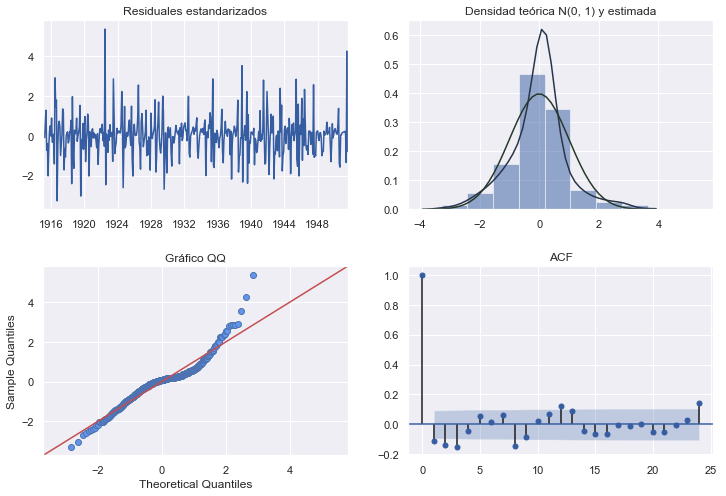

In [134]:
resid_diag(tree_resid)
plt.show()

In [135]:
print("Decision Tree")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(tree_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(tree_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(tree_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, tree_undiff_forecast))))
print("MAE (test):  " + str(mae(test, tree_undiff_forecast)))
print("sMAPE (test):  " + str(smape(test, tree_undiff_forecast)))

Decision Tree

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 1.2372416779099734e-51
Test de Ljung-Box para k =  6 (p-valor): 0.00023462568230369247
Test de Ljung-Box para k = 12 (p-valor): 6.963358532075138e-07

RMSE (test): 114.28259407187224
MAE (test):  93.38271343999499
sMAPE (test):  163.26939411832194


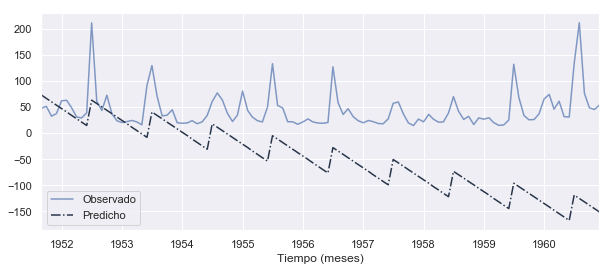

In [136]:
forecast_plot(test, tree_undiff_forecast)
plt.show()

##### Random Forest

In [137]:
best_score, best_tree = float("inf"), None

n_estimators = [50, 100, 200, 500]
depths = np.linspace(1, 61, 20)
max_features = [0.8, 1]


for n in n_estimators:
    for depth in depths:
        for features in max_features:
            rf = RandomForestRegressor(n_estimators=n,
                                       max_depth=depth,
                                       max_features=features,
                                       random_state=seed)
        
            rf_model1 = rf.fit(X_train1, y_train1)
            rf_forecast = iter_forecast(rf_model1, y_train1, 12, validation1)
            rmse1 = sqrt(mse(validation1.iloc[:,-1], rf_forecast))
        
            rf_model2 = rf.fit(X_val1, y_val1)
            rf_forecast = iter_forecast(rf_model2, y_val1, 12, validation2)
            rmse2 = sqrt(mse(validation2.iloc[:,-1], rf_forecast))
        
            rf_model3 = rf.fit(X_val2, y_val2)
            rf_forecast = iter_forecast(rf_model3, y_val2, 12, validation3)
            rmse3 = sqrt(mse(validation3.iloc[:,-1], rf_forecast))
        
            cvrmse = mean([rmse1, rmse2, rmse3])        
            if cvrmse < best_score:
                best_score, best_rf = cvrmse, rf.get_params()
        
print('Best RF: n_estimators: %s max_depth: %s max_features :%s | CV RMSE = %.3f'
      % (best_rf['n_estimators'], best_rf['max_depth'], best_rf['max_features'], best_score))

Best RF: n_estimators: 200 max_depth: 19.94736842105263 max_features :0.8 | CV RMSE = 28.999


In [138]:
rf_hyp = {"max_depth": 19.95,
          "n_estimators": 200,
          "max_features": 0.8}

In [139]:
rf = RandomForestRegressor(max_depth=rf_hyp["max_depth"],
                           n_estimators=rf_hyp["n_estimators"],
                           max_features=rf_hyp["max_features"])
rf_model = rf.fit(X_train, y_train)
rf_fitted = pd.Series(rf_model.predict(X_train))
rf_fitted
rf_fitted.index = X_train.index
rf_resid = y_train - rf_fitted
rf_resid = (rf_resid - rf_resid.mean()) / rf_resid.std()

rf_jb_test = jb(rf_resid)
rf_lb_test = lb(rf_resid)

rf_forecast = iter_forecast(rf, y_train, 12, test)

In [140]:
rf_undiff_forecast = []
last_obser = train.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + rf_forecast[i]
    rf_undiff_forecast.append(yhat)
    last_obser = yhat
    
rf_undiff_forecast = pd.Series(rf_undiff_forecast)
rf_undiff_forecast.index = test.index

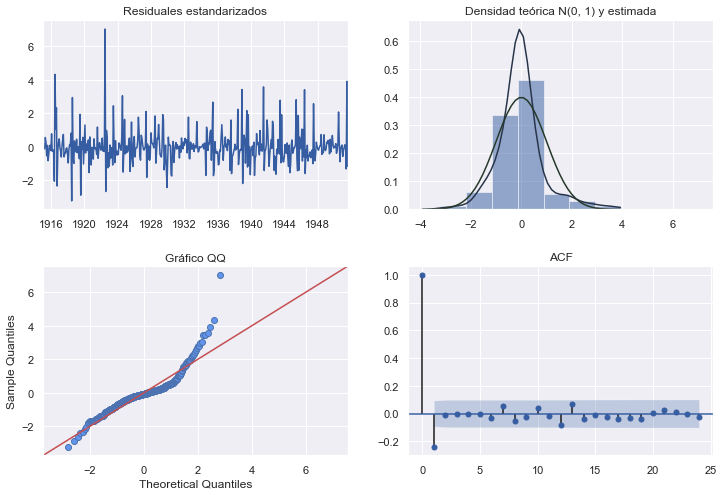

In [141]:
resid_diag(rf_resid)
plt.show()

In [142]:
print("Random Forest")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(rf_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(rf_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(rf_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, rf_undiff_forecast))))
print("MAE (test):  " + str(mae(test, rf_undiff_forecast)))
print("sMAPE (test):  " + str(smape(test, rf_undiff_forecast)))

Random Forest

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 1.2628792392400582e-276
Test de Ljung-Box para k =  6 (p-valor): 0.000340694012737027
Test de Ljung-Box para k = 12 (p-valor): 0.0007856372962224352

RMSE (test): 49.99219208276194
MAE (test):  43.52829952097113
sMAPE (test):  74.06849193480416


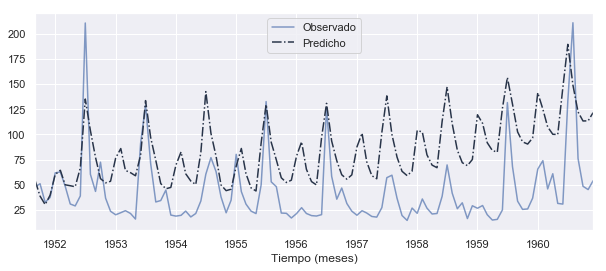

In [143]:
forecast_plot(test, rf_undiff_forecast)
plt.show()

##### ElasticNet

In [144]:
best_score, best_tree = float("inf"), None

ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alpha = [0, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]


for rat in ratio:
    for alp in alpha:
        en = ElasticNet(l1_ratio=rat, alpha=alp, random_state=seed)
        
        en_model1 = en.fit(X_train1, y_train1)
        en_forecast = iter_forecast(en_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], en_forecast))
        
        en_model2 = en.fit(X_val1, y_val1)
        en_forecast = iter_forecast(en_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], en_forecast))
        
        en_model3 = en.fit(X_val2, y_val2)
        en_forecast = iter_forecast(en_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], en_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
        if cvrmse < best_score:
            best_score, best_en = cvrmse, en.get_params()
        
print('Best EN: ratio: %s alpha: %s | CV RMSE = %.3f' %
      (best_en['l1_ratio'], best_en['alpha'], best_score))

Best EN: ratio: 0.1 alpha: 0 | CV RMSE = 31.409


In [145]:
en_hyp = {"l1_ratio": 0.1,
          "alpha": 0}

In [146]:
en = ElasticNet(l1_ratio=en_hyp["l1_ratio"], alpha=en_hyp["alpha"],
                random_state=seed)
en_model = en.fit(X_train, y_train)
en_fitted = pd.Series(en_model.predict(X_train))
en_fitted
en_fitted.index = X_train.index
en_resid = y_train - en_fitted
en_resid = (en_resid - en_resid.mean()) / en_resid.std()

en_jb_test = jb(en_resid)
en_lb_test = lb(en_resid)

en_forecast = iter_forecast(en, y_train, 12, test)

In [147]:
en_undiff_forecast = []
last_obser = train.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + en_forecast[i]
    en_undiff_forecast.append(yhat)
    last_obser = yhat
    
en_undiff_forecast = pd.Series(en_undiff_forecast)
en_undiff_forecast.index = test.index

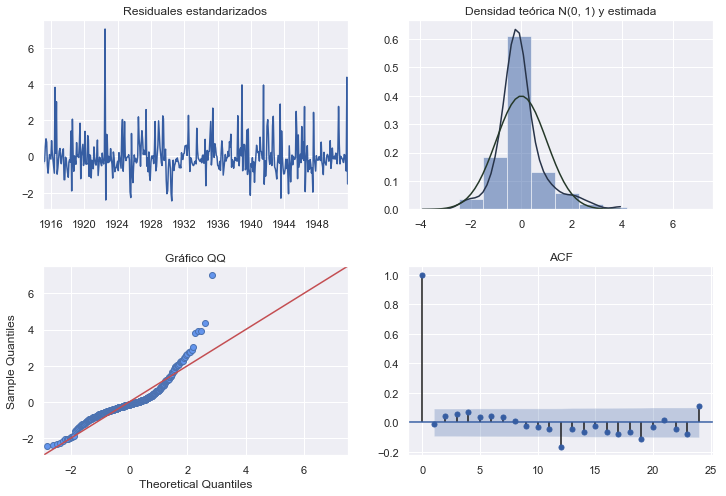

In [148]:
resid_diag(en_resid)
plt.show()

In [149]:
print("ElasticNet")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(en_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(en_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, en_undiff_forecast))))
print("MAE (test):  " + str(mae(test, en_undiff_forecast)))
print("sMAPE (test):  " + str(smape(test, en_undiff_forecast)))

ElasticNet

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Ljung-Box para k =  6 (p-valor): 0.49673055638329544
Test de Ljung-Box para k = 12 (p-valor): 0.07128341852182685

RMSE (test): 28.20851419327389
MAE (test):  19.41713375186481
sMAPE (test):  43.647066496865655


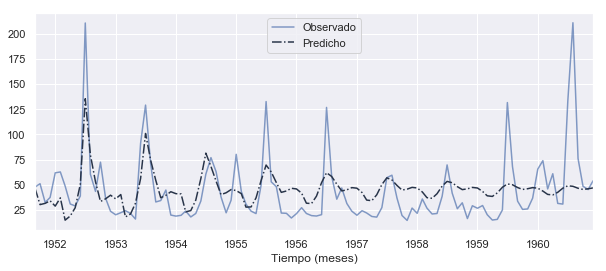

In [150]:
forecast_plot(test, en_undiff_forecast)
plt.show()

#### Serie temporal con Box-Cox y desestacionalizada como estructura de DataFrame

In [151]:
lag_df = series_to_supervised(bc_deseas, n_in=12)
lag_df.head(5)

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  \
index                                                                  
1915-01-01    2.104823    2.032305    2.058984   1.982896   1.945772   
1915-02-01    2.032305    2.058984    1.982896   1.945772   1.870234   
1915-03-01    2.058984    1.982896    1.945772   1.870234   1.894937   
1915-04-01    1.982896    1.945772    1.870234   1.894937   2.008061   
1915-05-01    1.945772    1.870234    1.894937   2.008061   2.104107   

            var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
index                                                                          
1915-01-01   1.870234   1.894937   2.008061   2.104107   2.094243   2.052516   
1915-02-01   1.894937   2.008061   2.104107   2.094243   2.052516   2.100102   
1915-03-01   2.008061   2.104107   2.094243   2.052516   2.100102   2.040468   
1915-04-01   2.104107   2.094243   2.052516   2.100102   2.040468   1.963905   
1915-05-01   2.094243   2.052516   2.100102   2.040468   1.963905   1.986410   

            var1(t-1)   var1(t)  
index                            
1915-01-01   2.100102  2.040468  
1915-02-01   2.040468  1.963905  
1915-03-01   1.963905  1.986410  
1915-04-01   1.986410  1.934452  
1915-05-01   1.934452  2.072123

#### Definición de X (predictoras) e y (a predecir)

In [152]:
X_train = lag_df.iloc[:,:-1]
y_train = lag_df.iloc[:,-1]

#### Validación cruzada temporal

In [153]:
train3, validation3 = ts_split(lag_df, train_size=0.75)
X_train3 = train3.iloc[:,:-1]
y_train3 = train3.iloc[:,-1]
X_val3 = validation3.iloc[:,:-1]
y_val3 = validation3.iloc[:,-1]

train2, validation2 = ts_split(train3, train_size=0.66)
X_train2 = train2.iloc[:,:-1]
y_train2 = train2.iloc[:,-1]
X_val2 = validation2.iloc[:,:-1]
y_val2 = validation2.iloc[:,-1]

train1, validation1 = ts_split(train2, train_size=0.5)
X_train1 = train1.iloc[:,:-1]
y_train1 = train1.iloc[:,-1]
X_val1 = validation1.iloc[:,:-1]
y_val1 = validation1.iloc[:,-1]

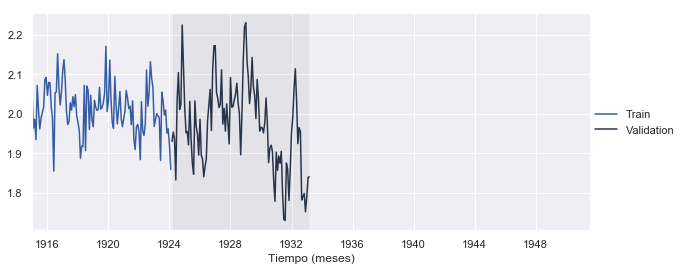

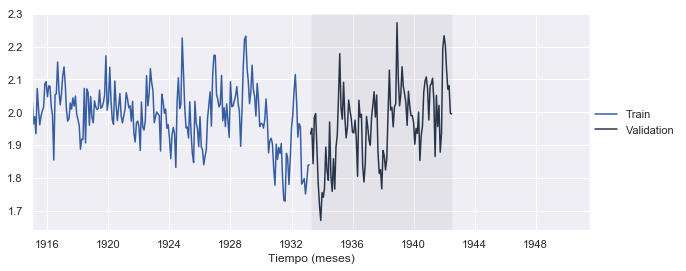

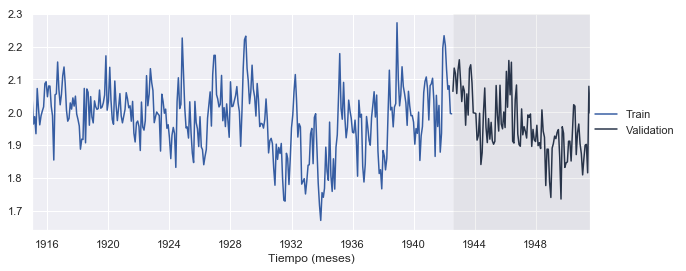

In [154]:
tscv_plot(train1["var1(t)"], validation1["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train2["var1(t)"], validation2["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train3["var1(t)"], validation3["var1(t)"], train.index[-1])
plt.show()

##### K-Nearest Neighbors 

In [155]:
neigb = list(np.arange(2, 41, 1))

In [156]:
best_score, best_knn = float("inf"), None

for k in neigb:    
        knn = KNeighborsRegressor(n_neighbors=k)
        
        knn_model1 = knn.fit(X_train1, y_train1)
        knn_forecast = iter_forecast(knn_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], knn_forecast))
        
        knn_model2 = knn.fit(X_val1, y_val1)
        knn_forecast = iter_forecast(knn_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], knn_forecast))
        
        knn_model3 = knn.fit(X_val2, y_val2)
        knn_forecast = iter_forecast(knn_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], knn_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])               
        if cvrmse < best_score:
            best_score, best_knn = cvrmse, knn.get_params()
        
print('Best KNN %s CVRMSE = %.3f' % (best_knn['n_neighbors'], best_score))

Best KNN 39 CVRMSE = 0.101


In [157]:
knn_hyp = {"k": 39}

In [158]:
knn = KNeighborsRegressor(n_neighbors=knn_hyp["k"])
knn_model = knn.fit(X_train, y_train)
knn_fitted = pd.Series(knn_model.predict(X_train))
knn_fitted
knn_fitted.index = X_train.index
knn_resid = y_train - knn_fitted
knn_resid = (knn_resid - knn_resid.mean()) / knn_resid.std()

knn_jb_test = jb(knn_resid)
knn_lb_test = lb(knn_resid)

knn_forecast = iter_forecast(knn, y_train, 12, test)

In [159]:
knn_seas_forecast = knn_forecast + bc_seasonality_forecast
knn_box_forecast = (bc_param * knn_seas_forecast + 1) ** (1 / bc_param)

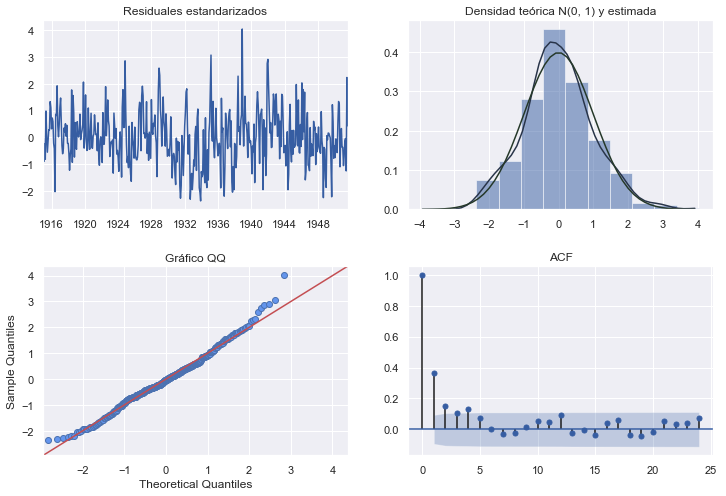

In [160]:
resid_diag(knn_resid)
plt.show()

In [161]:
print("K-Nearest Neighbors")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(knn_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(knn_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " + 
      str(knn_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, knn_box_forecast))))
print("MAE (test):  " + str(mae(test, knn_box_forecast)))
print("sMAPE (test):  " + str(smape(test, knn_box_forecast)))

K-Nearest Neighbors

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 0.0024537980554560092
Test de Ljung-Box para k =  6 (p-valor): 1.7902764790943185e-15
Test de Ljung-Box para k = 12 (p-valor): 7.567142794696897e-14

RMSE (test): 33.74267918581206
MAE (test):  20.81188937226639
sMAPE (test):  44.40053551108947


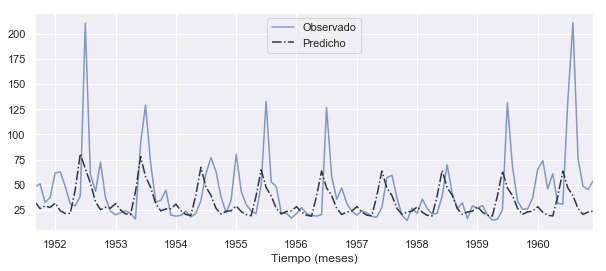

In [162]:
forecast_plot(test, knn_box_forecast)
plt.show()

##### Regresion tree

In [163]:
depths = list(np.arange(1, 21, 1))

In [164]:
best_score, best_tree = float("inf"), None

for depth in depths:    
        tree = DecisionTreeRegressor(max_depth=depth, random_state=seed)
        
        tree_model1 = tree.fit(X_train1, y_train1)
        tree_forecast = iter_forecast(tree_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], tree_forecast))
        
        tree_model2 = tree.fit(X_val1, y_val1)
        tree_forecast = iter_forecast(tree_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], tree_forecast))
        
        tree_model3 = tree.fit(X_val2, y_val2)
        tree_forecast = iter_forecast(tree_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], tree_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
        if cvrmse < best_score:
            best_score, best_tree = cvrmse, tree.get_params()
        
print('Best Tree %s CV RMSE = %.3f' % (best_tree['max_depth'], best_score))

Best Tree 6 CV RMSE = 0.116


In [165]:
tree_hyp = {"depth": 6}

In [166]:
tree = DecisionTreeRegressor(max_depth=tree_hyp["depth"],
                             random_state=seed)
tree_model = tree.fit(X_train, y_train)
tree_fitted = pd.Series(tree_model.predict(X_train))
tree_fitted
tree_fitted.index = X_train.index
tree_resid = y_train - tree_fitted
tree_resid = (tree_resid - tree_resid.mean()) / tree_resid.std()

tree_jb_test = jb(tree_resid)
tree_lb_test = lb(tree_resid)

tree_forecast = iter_forecast(tree, y_train, 12, test)

In [167]:
tree_seas_forecast = tree_forecast + bc_seasonality_forecast
tree_box_forecast = (bc_param * tree_seas_forecast + 1) ** (1 / bc_param)

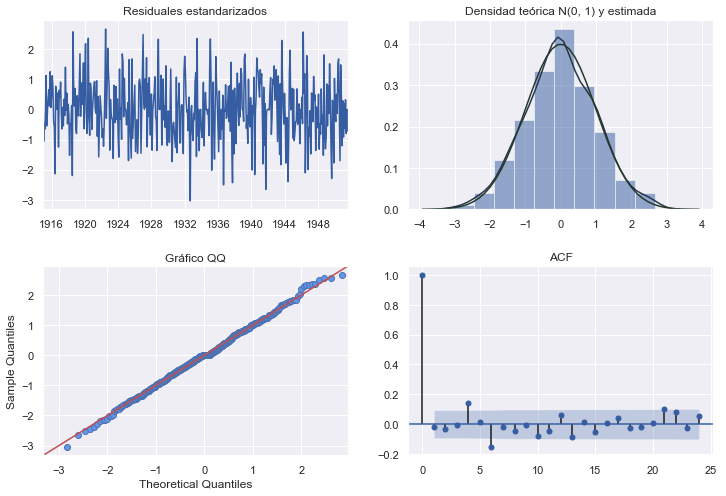

In [168]:
resid_diag(tree_resid)
plt.show()

In [169]:
print("Decision Tree")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(tree_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(tree_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(tree_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, tree_box_forecast))))
print("MAE (test):  " + str(mae(test, tree_box_forecast)))
print("sMAPE (test):  " + str(smape(test, tree_box_forecast)))

Decision Tree

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 0.9929874413510592
Test de Ljung-Box para k =  6 (p-valor): 0.00618239070831623
Test de Ljung-Box para k = 12 (p-valor): 0.005802475974333508

RMSE (test): 35.1622944094888
MAE (test):  22.43908436319708
sMAPE (test):  44.0630152274956


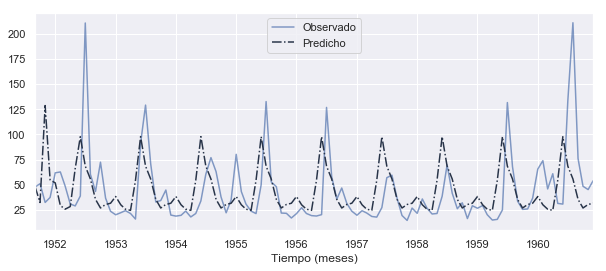

In [170]:
forecast_plot(test, tree_box_forecast)
plt.show()

##### Random Forest

In [172]:
depths = np.linspace(1, 61, 21)

In [173]:
best_score, best_tree = float("inf"), None

n_estimators = [50, 100, 200, 500]
depths = np.linspace(1, 61, 20)
max_features = [0.8, 1]


for n in n_estimators:
    for depth in depths:
        for features in max_features:
            rf = RandomForestRegressor(n_estimators=n,
                                       max_depth=depth,
                                       max_features=features,
                                       random_state=seed)
        
            rf_model1 = rf.fit(X_train1, y_train1)
            rf_forecast = iter_forecast(rf_model1, y_train1, 12, validation1)
            rmse1 = sqrt(mse(validation1.iloc[:,-1], rf_forecast))
        
            rf_model2 = rf.fit(X_val1, y_val1)
            rf_forecast = iter_forecast(rf_model2, y_val1, 12, validation2)
            rmse2 = sqrt(mse(validation2.iloc[:,-1], rf_forecast))
        
            rf_model3 = rf.fit(X_val2, y_val2)
            rf_forecast = iter_forecast(rf_model3, y_val2, 12, validation3)
            rmse3 = sqrt(mse(validation3.iloc[:,-1], rf_forecast))
        
            cvrmse = mean([rmse1, rmse2, rmse3])        
            if cvrmse < best_score:
                best_score, best_rf = cvrmse, rf.get_params()
        
print('Best RF: n_estimators: %s max_depth: %s max_features :%s | CV RMSE = %.3f' % 
      (best_rf['n_estimators'], best_rf['max_depth'], best_rf['max_features'], best_score))

Best RF: n_estimators: 500 max_depth: 1.0 max_features :1 | CV RMSE = 0.107


In [174]:
rf_hyp = {"max_depth": 1,
          "n_estimators": 500,
          "max_features": 1}

In [175]:
rf = RandomForestRegressor(max_depth=rf_hyp["max_depth"],
                           n_estimators=rf_hyp["n_estimators"],
                           max_features=rf_hyp["max_features"],
                           random_state=seed)

rf_model = rf.fit(X_train, y_train)
rf_fitted = pd.Series(rf_model.predict(X_train))
rf_fitted
rf_fitted.index = X_train.index
rf_resid = y_train - rf_fitted
rf_resid = (rf_resid - rf_resid.mean()) / rf_resid.std()

rf_jb_test = jb(rf_resid)
rf_lb_test = lb(rf_resid)

rf_forecast = iter_forecast(rf, y_train, 12, test)

In [176]:
rf_seas_forecast = rf_forecast + bc_seasonality_forecast
rf_box_forecast = (bc_param * rf_seas_forecast + 1) ** (1 / bc_param)

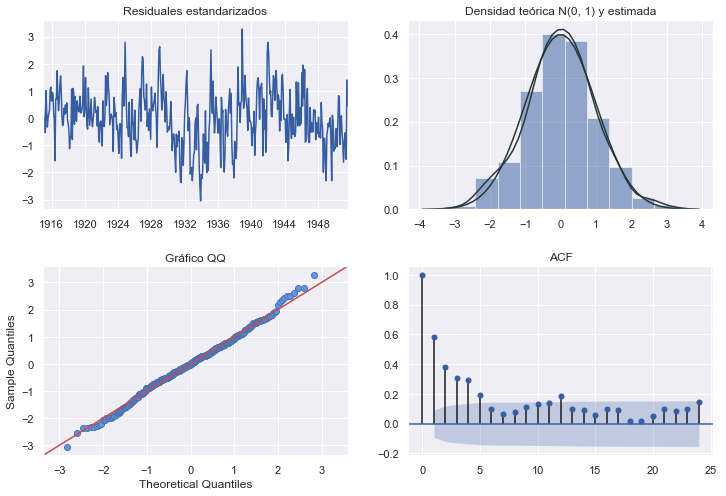

In [177]:
resid_diag(rf_resid)
plt.show()

In [178]:
print("Random Forest")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(rf_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(rf_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(rf_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, rf_box_forecast))))
print("MAE (test):  " + str(mae(test, rf_box_forecast)))
print("sMAPE (test):  " + str(smape(test, rf_box_forecast)))

Random Forest

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 0.4770988921732303
Test de Ljung-Box para k =  6 (p-valor): 4.8204864865797315e-65
Test de Ljung-Box para k = 12 (p-valor): 7.749578074539412e-70

RMSE (test): 34.36997958512307
MAE (test):  22.24758706621245
sMAPE (test):  44.313099901978816


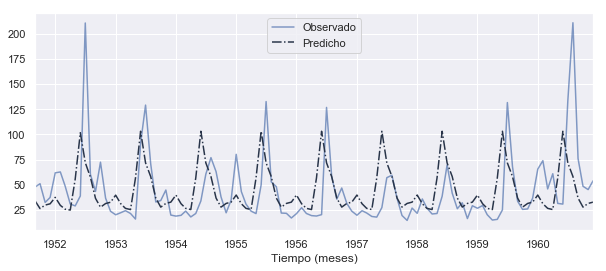

In [179]:
forecast_plot(test, rf_box_forecast)
plt.show()

##### ElasticNet

In [180]:
best_score, best_tree = float("inf"), None

ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alpha = [0, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]


for rat in ratio:
    for alp in alpha:
        en = ElasticNet(l1_ratio=rat, alpha=alp, random_state=seed)
        
        en_model1 = en.fit(X_train1, y_train1)
        en_forecast = iter_forecast(en_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], en_forecast))
        
        en_model2 = en.fit(X_val1, y_val1)
        en_forecast = iter_forecast(en_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], en_forecast))
        
        en_model3 = en.fit(X_val2, y_val2)
        en_forecast = iter_forecast(en_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], en_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
        if cvrmse < best_score:
            best_score, best_en = cvrmse, en.get_params()
        
print('Best EN: ratio: %s alpha: %s | CV RMSE = %.3f' %
      (best_en['l1_ratio'], best_en['alpha'], best_score))

Best EN: ratio: 0.1 alpha: 0 | CV RMSE = 0.106


In [181]:
en_hyp = {"l1_ratio": 0.1,
          "alpha": 0}

In [182]:
en = ElasticNet(l1_ratio=en_hyp["l1_ratio"], alpha=en_hyp["alpha"],
                random_state=seed)
en_model = en.fit(X_train, y_train)
en_fitted = pd.Series(en_model.predict(X_train))
en_fitted
en_fitted.index = X_train.index
en_resid = y_train - en_fitted
en_resid = (en_resid - en_resid.mean()) / en_resid.std()

en_jb_test = jb(en_resid)
en_lb_test = lb(en_resid)

en_forecast = iter_forecast(en, y_train, 12, test)

In [183]:
en_seas_forecast = en_forecast + bc_seasonality_forecast
en_box_forecast = (bc_param * en_seas_forecast + 1) ** (1 / bc_param)

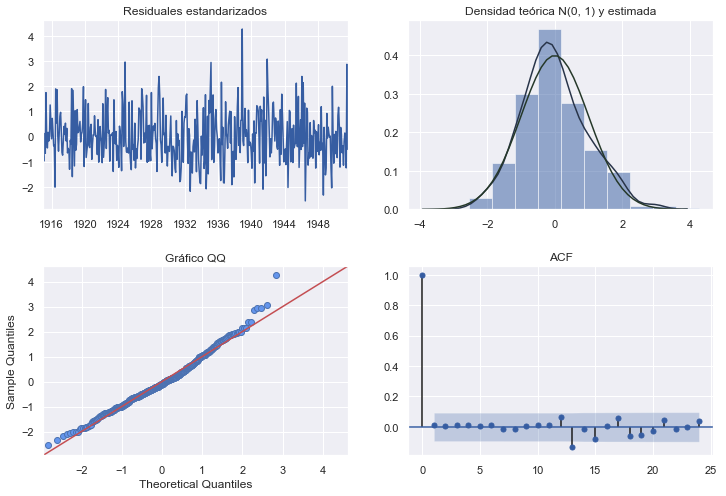

In [184]:
resid_diag(en_resid)
plt.show()

In [185]:
print("ElasticNet")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(en_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(en_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(en_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, en_box_forecast))))
print("MAE (test):  " + str(mae(test, en_box_forecast)))
print("sMAPE (test):  " + str(smape(test, en_box_forecast)))

ElasticNet

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 7.412106994966741e-06
Test de Ljung-Box para k =  6 (p-valor): 0.9996200800570041
Test de Ljung-Box para k = 12 (p-valor): 0.6760069479969495

RMSE (test): 34.0536545700252
MAE (test):  21.710813026623878
sMAPE (test):  43.73798854561817


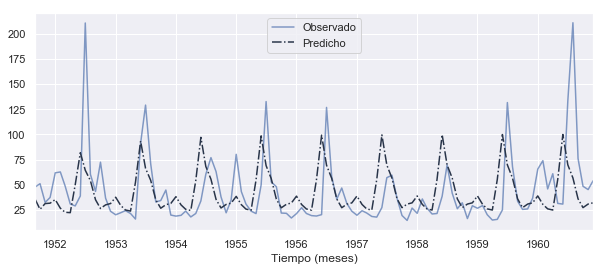

In [186]:
forecast_plot(test, en_box_forecast)
plt.show()

#### Serie temporal con Box-Cox y diferenciada como estructura de DataFrame

In [187]:
lag_df = series_to_supervised(diff_bc_train, n_in=12)
lag_df.head(5)

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  \
index                                                                  
1915-02-01   -0.022415   -0.036931   -0.120520  -0.050707   0.127983   
1915-03-01   -0.036931   -0.120520   -0.050707   0.127983   0.140010   
1915-04-01   -0.120520   -0.050707    0.127983   0.140010   0.046348   
1915-05-01   -0.050707    0.127983    0.140010   0.046348   0.053055   
1915-06-01    0.127983    0.140010    0.046348   0.053055  -0.117011   

            var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
index                                                                          
1915-02-01   0.140010   0.046348   0.053055  -0.117011  -0.117013   0.081798   
1915-03-01   0.046348   0.053055  -0.117011  -0.117013   0.081798  -0.048950   
1915-04-01   0.053055  -0.117011  -0.117013   0.081798  -0.048950  -0.026461   
1915-05-01  -0.117011  -0.117013   0.081798  -0.048950  -0.026461  -0.041104   
1915-06-01  -0.117013   0.081798  -0.048950  -0.026461  -0.041104  -0.096391   

            var1(t-1)   var1(t)  
index                            
1915-02-01  -0.048950 -0.026461  
1915-03-01  -0.026461 -0.041104  
1915-04-01  -0.041104 -0.096391  
1915-05-01  -0.096391  0.124088  
1915-06-01   0.124088  0.142337

#### Definición de X (predictoras) e y (a predecir)

In [188]:
X_train = lag_df.iloc[:,:-1]
y_train = lag_df.iloc[:,-1]

#### Validación cruzada temporal

In [189]:
train3, validation3 = ts_split(lag_df, train_size=0.75)
X_train3 = train3.iloc[:,:-1]
y_train3 = train3.iloc[:,-1]
X_val3 = validation3.iloc[:,:-1]
y_val3 = validation3.iloc[:,-1]

train2, validation2 = ts_split(train3, train_size=0.66)
X_train2 = train2.iloc[:,:-1]
y_train2 = train2.iloc[:,-1]
X_val2 = validation2.iloc[:,:-1]
y_val2 = validation2.iloc[:,-1]

train1, validation1 = ts_split(train2, train_size=0.5)
X_train1 = train1.iloc[:,:-1]
y_train1 = train1.iloc[:,-1]
X_val1 = validation1.iloc[:,:-1]
y_val1 = validation1.iloc[:,-1]

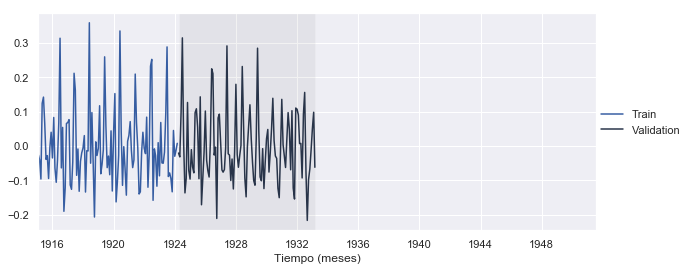

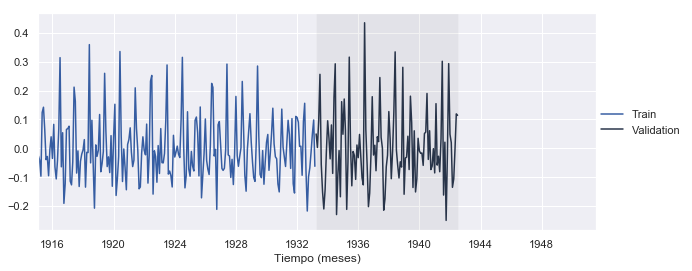

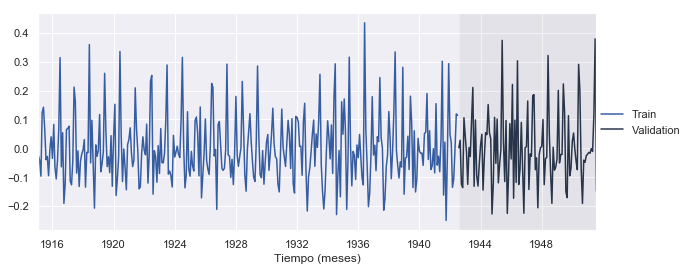

In [190]:
tscv_plot(train1["var1(t)"], validation1["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train2["var1(t)"], validation2["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train3["var1(t)"], validation3["var1(t)"], train.index[-1])
plt.show()

##### K-Nearest Neighbors 

In [191]:
neigb = list(np.arange(2, 41, 1))

In [192]:
best_score, best_knn = float("inf"), None

for k in neigb:    
        knn = KNeighborsRegressor(n_neighbors=k)
        
        knn_model1 = knn.fit(X_train1, y_train1)
        knn_forecast = iter_forecast(knn_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], knn_forecast))
        
        knn_model2 = knn.fit(X_val1, y_val1)
        knn_forecast = iter_forecast(knn_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], knn_forecast))
        
        knn_model3 = knn.fit(X_val2, y_val2)
        knn_forecast = iter_forecast(knn_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], knn_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])        
        if cvrmse < best_score:
            best_score, best_knn = cvrmse, knn.get_params()
        
print('Best KNN %s CVRMSE = %.3f' % (best_knn['n_neighbors'], best_score))

Best KNN 21 CVRMSE = 0.102


In [193]:
knn_hyp = {"k": 21}

In [194]:
knn = KNeighborsRegressor(n_neighbors=knn_hyp["k"])
knn_model = knn.fit(X_train, y_train)
knn_fitted = pd.Series(knn_model.predict(X_train))
knn_fitted
knn_fitted.index = X_train.index
knn_resid = y_train - knn_fitted
knn_resid = (knn_resid - knn_resid.mean()) / knn_resid.std()

knn_jb_test = jb(knn_resid)
knn_lb_test = lb(knn_resid)

knn_forecast = iter_forecast(knn, y_train, 12, test)

In [195]:
knn_undiff_forecast = []
last_obser = bc_train.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + knn_forecast[i]
    knn_undiff_forecast.append(yhat)
    last_obser = yhat
    
knn_undiff_forecast = pd.Series(knn_undiff_forecast)
knn_undiff_forecast.index = test.index

In [196]:
knn_box_forecast = (bc_param * knn_undiff_forecast + 1) ** (1 / bc_param)

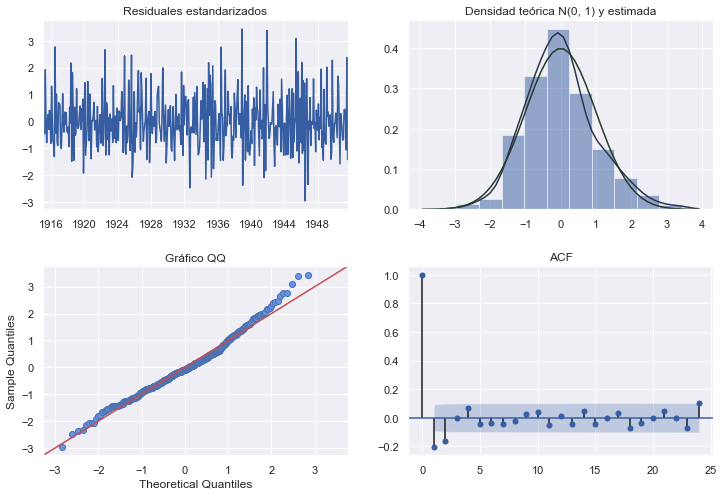

In [197]:
resid_diag(knn_resid)
plt.show()

In [198]:
print("K-Nearest Neighbors")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + 
      str(knn_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(knn_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(knn_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, knn_box_forecast))))
print("MAE (test):  " + str(mae(test, knn_box_forecast)))
print("sMAPE (test):  " + str(smape(test, knn_box_forecast)))

K-Nearest Neighbors

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 4.5246797922048964e-05
Test de Ljung-Box para k =  6 (p-valor): 1.426702194406454e-05
Test de Ljung-Box para k = 12 (p-valor): 0.0002938382649062492

RMSE (test): 27.372119226343877
MAE (test):  16.042767653266925
sMAPE (test):  34.04440035728844


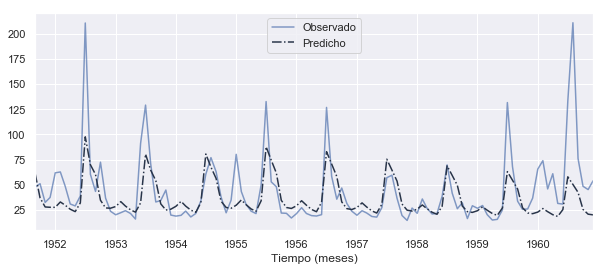

In [199]:
forecast_plot(test, knn_box_forecast)
plt.show()

##### Regresion tree

In [200]:
depths = list(np.arange(1, 21, 1))

In [201]:
best_score, best_tree = float("inf"), None

for depth in depths:    
        tree = DecisionTreeRegressor(max_depth=depth, random_state=seed)
        
        tree_model1 = tree.fit(X_train1, y_train1)
        tree_forecast = iter_forecast(tree_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], tree_forecast))
        
        tree_model2 = tree.fit(X_val1, y_val1)
        tree_forecast = iter_forecast(tree_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], tree_forecast))
        
        tree_model3 = tree.fit(X_val2, y_val2)
        tree_forecast = iter_forecast(tree_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], tree_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
        
        if cvrmse < best_score:
            best_score, best_tree = cvrmse, tree.get_params()
        
print('Best Tree %s CV RMSE = %.3f' % (best_tree['max_depth'], best_score))

Best Tree 1 CV RMSE = 0.120


In [202]:
tree_hyp = {"depth": 1}

In [203]:
tree = DecisionTreeRegressor(max_depth=tree_hyp["depth"],
                             random_state=seed)
tree_model = tree.fit(X_train, y_train)
tree_fitted = pd.Series(tree_model.predict(X_train))
tree_fitted
tree_fitted.index = X_train.index
tree_resid = y_train - tree_fitted
tree_resid = (tree_resid - tree_resid.mean()) / tree_resid.std()

tree_jb_test = jb(tree_resid)
tree_lb_test = lb(tree_resid)

tree_forecast = iter_forecast(tree, y_train, 12, test)

In [204]:
tree_undiff_forecast = []
last_obser = bc_train.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + tree_forecast[i]
    tree_undiff_forecast.append(yhat)
    last_obser = yhat
    
tree_undiff_forecast = pd.Series(tree_undiff_forecast)
tree_undiff_forecast.index = test.index

In [205]:
tree_box_forecast = (bc_param * tree_undiff_forecast + 1) ** (1 / bc_param)

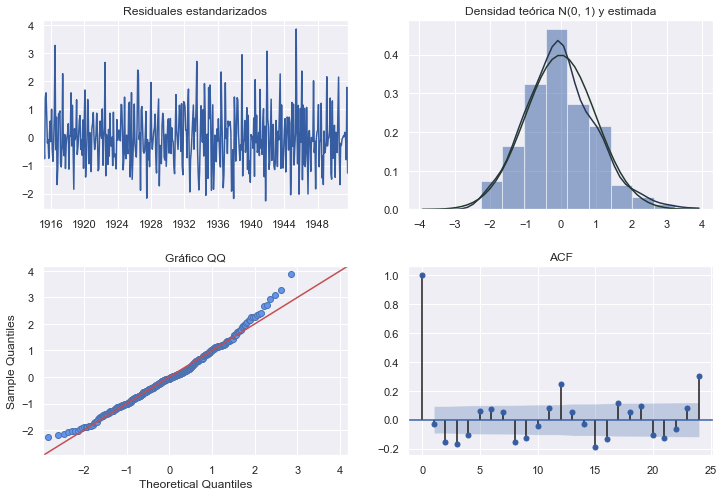

In [206]:
resid_diag(tree_resid)
plt.show()

In [207]:
print("Decision Tree")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " +
      str(tree_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(tree_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " + 
      str(tree_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, tree_box_forecast))))
print("MAE (test):  " + str(mae(test, tree_box_forecast)))
print("sMAPE (test):  " + str(smape(test, tree_box_forecast)))

Decision Tree

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 6.676127468555702e-05
Test de Ljung-Box para k =  6 (p-valor): 2.6885859567584192e-05
Test de Ljung-Box para k = 12 (p-valor): 1.6607113930256373e-12

RMSE (test): 30.862439905297794
MAE (test):  19.343326550124953
sMAPE (test):  41.765027713266996


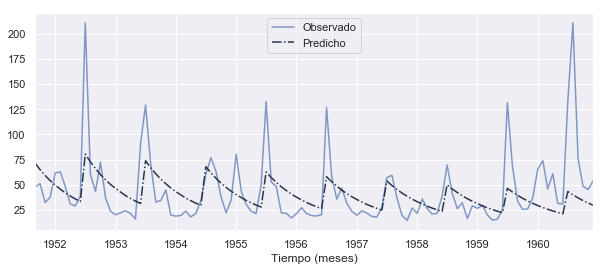

In [208]:
forecast_plot(test, tree_box_forecast)
plt.show()

##### Random Forest

In [209]:
best_score, best_tree = float("inf"), None

n_estimators = [50, 100, 200, 500]
depths = np.linspace(1, 61, 20)
max_features = [0.8, 1]


for n in n_estimators:
    for depth in depths:
        for features in max_features:
            rf = RandomForestRegressor(n_estimators=n,
                                       max_depth=depth,
                                       max_features=features,
                                       random_state=seed)
        
            rf_model1 = rf.fit(X_train1, y_train1)
            rf_forecast = iter_forecast(rf_model1, y_train1, 12, validation1)
            rmse1 = sqrt(mse(validation1.iloc[:,-1], rf_forecast))
        
            rf_model2 = rf.fit(X_val1, y_val1)
            rf_forecast = iter_forecast(rf_model2, y_val1, 12, validation2)
            rmse2 = sqrt(mse(validation2.iloc[:,-1], rf_forecast))
        
            rf_model3 = rf.fit(X_val2, y_val2)
            rf_forecast = iter_forecast(rf_model3, y_val2, 12, validation3)
            rmse3 = sqrt(mse(validation3.iloc[:,-1], rf_forecast))
        
            cvrmse = mean([rmse1, rmse2, rmse3])        
            if cvrmse < best_score:
                best_score, best_rf = cvrmse, rf.get_params()
        
print('Best RF: n_estimators: %s max_depth: %s max_features :%s | CV RMSE = %.3f' 
      % (best_rf['n_estimators'], best_rf['max_depth'], best_rf['max_features'], best_score))

Best RF: n_estimators: 500 max_depth: 4.157894736842105 max_features :0.8 | CV RMSE = 0.113


In [210]:
rf_hyp = {"max_depth": 4.15,
          "n_estimators": 500,
          "max_features": 0.8}

In [211]:
rf = RandomForestRegressor(max_depth=rf_hyp["max_depth"], 
                           n_estimators=rf_hyp["n_estimators"],
                           max_features=rf_hyp["max_features"],
                           random_state=seed)

rf_model = rf.fit(X_train, y_train)
rf_fitted = pd.Series(rf_model.predict(X_train))
rf_fitted
rf_fitted.index = X_train.index
rf_resid = y_train - rf_fitted
rf_resid = (rf_resid - rf_resid.mean()) / rf_resid.std()

rf_jb_test = jb(rf_resid)
rf_lb_test = lb(rf_resid)

rf_forecast = iter_forecast(rf, y_train, 12, test)

In [212]:
rf_undiff_forecast = []
last_obser = bc_deseas.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + rf_forecast[i]
    rf_undiff_forecast.append(yhat)
    last_obser = yhat
    
rf_undiff_forecast = pd.Series(rf_undiff_forecast)
rf_undiff_forecast.index = test.index

In [213]:
rf_box_forecast = (bc_param * rf_undiff_forecast + 1) ** (1 / bc_param)

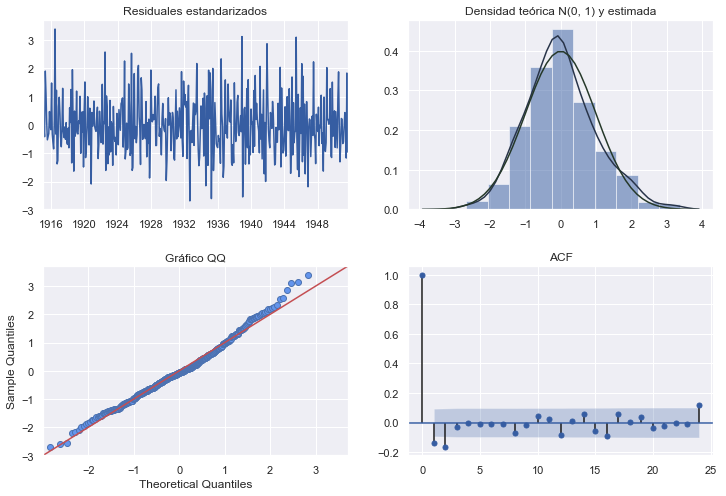

In [214]:
resid_diag(rf_resid)
plt.show()

In [215]:
print("Random Forest")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(rf_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(rf_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(rf_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, rf_box_forecast))))
print("MAE (test):  " + str(mae(test, rf_box_forecast)))
print("sMAPE (test):  " + str(smape(test, rf_box_forecast)))

Random Forest

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 0.0017866076588243709
Test de Ljung-Box para k =  6 (p-valor): 0.0036130029610332488
Test de Ljung-Box para k = 12 (p-valor): 0.008784333768246519

RMSE (test): 43.79388980909914
MAE (test):  29.732433883121928
sMAPE (test):  90.94202211425733


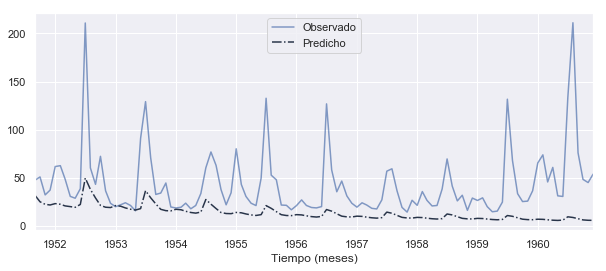

In [216]:
forecast_plot(test, rf_box_forecast)
plt.show()

##### ElasticNet

In [217]:
best_score, best_tree = float("inf"), None

ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alpha = [0, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]


for rat in ratio:
    for alp in alpha:
        en = ElasticNet(l1_ratio=rat, alpha=alp, random_state=seed)
        
        en_model1 = en.fit(X_train1, y_train1)
        en_forecast = iter_forecast(en_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], en_forecast))
        
        en_model2 = en.fit(X_val1, y_val1)
        en_forecast = iter_forecast(en_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], en_forecast))
        
        en_model3 = en.fit(X_val2, y_val2)
        en_forecast = iter_forecast(en_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], en_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
        if cvrmse < best_score:
            best_score, best_en = cvrmse, en.get_params()
        
print('Best EN: ratio: %s alpha: %s | CV RMSE = %.3f' %
      (best_en['l1_ratio'], best_en['alpha'], best_score))

Best EN: ratio: 0.1 alpha: 0 | CV RMSE = 0.111


In [218]:
en_hyp = {"l1_ratio": 0.1,
          "alpha": 0}

In [219]:
en = ElasticNet(l1_ratio=en_hyp["l1_ratio"], alpha=en_hyp["alpha"],
                random_state=seed)
en_model = en.fit(X_train, y_train)
en_fitted = pd.Series(en_model.predict(X_train))
en_fitted
en_fitted.index = X_train.index
en_resid = y_train - en_fitted
en_resid = (en_resid - en_resid.mean()) / en_resid.std()

en_jb_test = jb(en_resid)
en_lb_test = lb(en_resid)

en_forecast = iter_forecast(en, y_train, 12, test)

In [220]:
en_undiff_forecast = []
last_obser = bc_train.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + en_forecast[i]
    en_undiff_forecast.append(yhat)
    last_obser = yhat
    
en_undiff_forecast = pd.Series(en_undiff_forecast)
en_undiff_forecast.index = test.index

In [221]:
en_box_forecast = (bc_param * en_undiff_forecast + 1) ** (1 / bc_param)

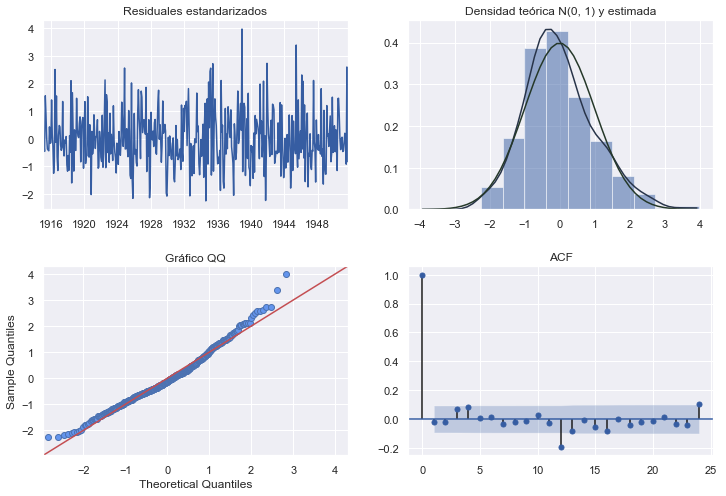

In [222]:
resid_diag(en_resid)
plt.show()

In [223]:
print("ElasticNet")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(en_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(en_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(en_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, en_box_forecast))))
print("MAE (test):  " + str(mae(test, en_box_forecast)))
print("sMAPE (test):  " + str(smape(test, en_box_forecast)))

ElasticNet

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 1.621113733273755e-06
Test de Ljung-Box para k =  6 (p-valor): 0.5239960585921445
Test de Ljung-Box para k = 12 (p-valor): 0.012392484507714213

RMSE (test): 33.327165564718044
MAE (test):  18.778881608977922
sMAPE (test):  39.585127561297675


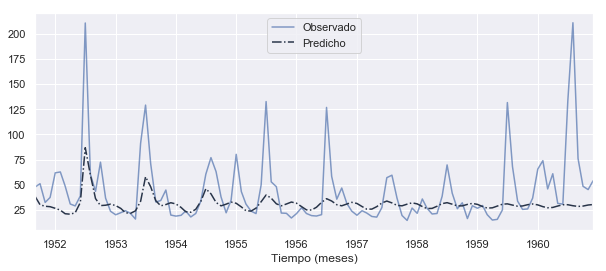

In [224]:
forecast_plot(test, en_box_forecast)
plt.show()

#### Serie temporal desestacionalizada y diferenciada como estructura de DataFrame

In [225]:
diff_deseas = deseas.diff(1).iloc[1:]

In [226]:
lag_df = series_to_supervised(diff_deseas, n_in=12)
lag_df.head(5)

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  \
index                                                                  
1915-02-01  -12.568751    4.257272  -10.102387  -2.545743 -27.175797   
1915-03-01    4.257272  -10.102387   -2.545743 -27.175797 -17.669263   
1915-04-01  -10.102387   -2.545743  -27.175797 -17.669263  54.286194   
1915-05-01   -2.545743  -27.175797  -17.669263  54.286194  39.474457   
1915-06-01  -27.175797  -17.669263   54.286194  39.474457 -25.286546   

            var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
index                                                                          
1915-02-01 -17.669263  54.286194  39.474457 -25.286546 -14.752516   8.114108   
1915-03-01  54.286194  39.474457 -25.286546 -14.752516   8.114108  -9.567028   
1915-04-01  39.474457 -25.286546 -14.752516   8.114108  -9.567028 -11.491751   
1915-05-01 -25.286546 -14.752516   8.114108  -9.567028 -11.491751   6.097272   
1915-06-01 -14.752516   8.114108  -9.567028 -11.491751   6.097272  -3.561387   

            var1(t-1)    var1(t)  
index                             
1915-02-01  -9.567028 -11.491751  
1915-03-01 -11.491751   6.097272  
1915-04-01   6.097272  -3.561387  
1915-05-01  -3.561387  14.444257  
1915-06-01  14.444257  -9.590797

#### Definición de X (predictoras) e y (a predecir)

In [227]:
X_train = lag_df.iloc[:,:-1]
y_train = lag_df.iloc[:,-1]

#### Validación cruzada temporal

In [228]:
train3, validation3 = ts_split(lag_df, train_size=0.75)
X_train3 = train3.iloc[:,:-1]
y_train3 = train3.iloc[:,-1]
X_val3 = validation3.iloc[:,:-1]
y_val3 = validation3.iloc[:,-1]

train2, validation2 = ts_split(train3, train_size=0.66)
X_train2 = train2.iloc[:,:-1]
y_train2 = train2.iloc[:,-1]
X_val2 = validation2.iloc[:,:-1]
y_val2 = validation2.iloc[:,-1]

train1, validation1 = ts_split(train2, train_size=0.5)
X_train1 = train1.iloc[:,:-1]
y_train1 = train1.iloc[:,-1]
X_val1 = validation1.iloc[:,:-1]
y_val1 = validation1.iloc[:,-1]

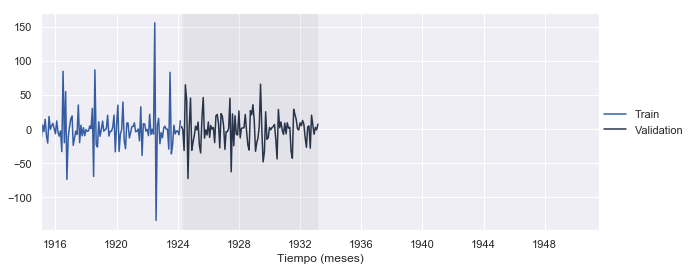

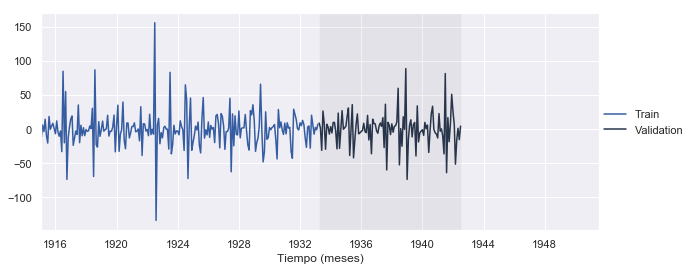

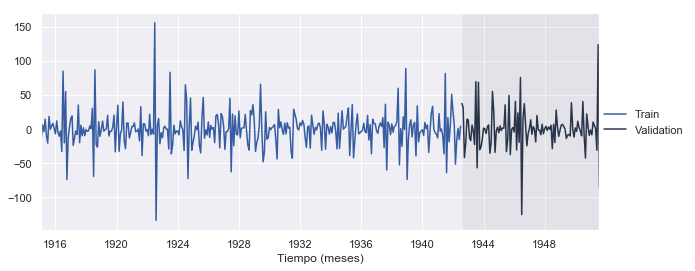

In [229]:
tscv_plot(train1["var1(t)"], validation1["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train2["var1(t)"], validation2["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train3["var1(t)"], validation3["var1(t)"], train.index[-1])
plt.show()

##### K-Nearest Neighbors 

In [230]:
neigb = list(np.arange(2, 41, 1))

In [231]:
best_score, best_knn = float("inf"), None

for k in neigb:    
        knn = KNeighborsRegressor(n_neighbors=k)
        
        knn_model1 = knn.fit(X_train1, y_train1)
        knn_forecast = iter_forecast(knn_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], knn_forecast))
        
        knn_model2 = knn.fit(X_val1, y_val1)
        knn_forecast = iter_forecast(knn_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], knn_forecast))
        
        knn_model3 = knn.fit(X_val2, y_val2)
        knn_forecast = iter_forecast(knn_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], knn_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])        
        if cvrmse < best_score:
            best_score, best_knn = cvrmse, knn.get_params()
        
print('Best KNN %s CVRMSE = %.3f' % (best_knn['n_neighbors'], best_score))

Best KNN 33 CVRMSE = 25.992


In [232]:
knn_hyp = {"k": 33}

In [233]:
knn = KNeighborsRegressor(n_neighbors=knn_hyp["k"])
knn_model = knn.fit(X_train, y_train)
knn_fitted = pd.Series(knn_model.predict(X_train))
knn_fitted
knn_fitted.index = X_train.index
knn_resid = y_train - knn_fitted
knn_resid = (knn_resid - knn_resid.mean()) / knn_resid.std()

knn_jb_test = jb(knn_resid)
knn_lb_test = lb(knn_resid)

knn_forecast = iter_forecast(knn, y_train, 12, test)

In [234]:
knn_undiff_forecast = []
last_obser = deseas.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + knn_forecast[i]
    knn_undiff_forecast.append(yhat)
    last_obser = yhat
    
knn_undiff_forecast = pd.Series(knn_undiff_forecast)
knn_undiff_forecast.index = test.index

In [235]:
knn_seas_forecast = knn_undiff_forecast + seasonality_forecast

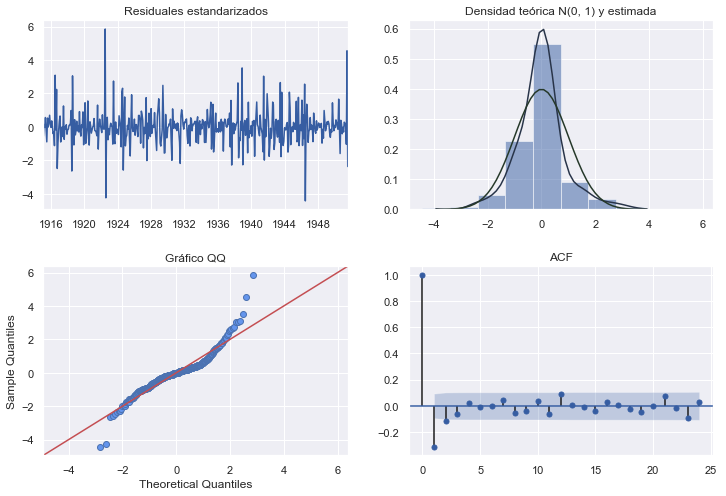

In [236]:
resid_diag(knn_resid)
plt.show()

In [237]:
print("K-Nearest Neighbors")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(knn_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +      
      str(knn_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(knn_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, knn_seas_forecast))))
print("MAE (test):  " + str(mae(test, knn_seas_forecast)))
print("sMAPE (test):  " + str(smape(test, knn_seas_forecast)))

K-Nearest Neighbors

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 5.717097260166605e-124
Test de Ljung-Box para k =  6 (p-valor): 7.070382754371443e-09
Test de Ljung-Box para k = 12 (p-valor): 5.902152283903449e-08

RMSE (test): 84.05832496249754
MAE (test):  63.474552623087746
sMAPE (test):  132.40169832978398


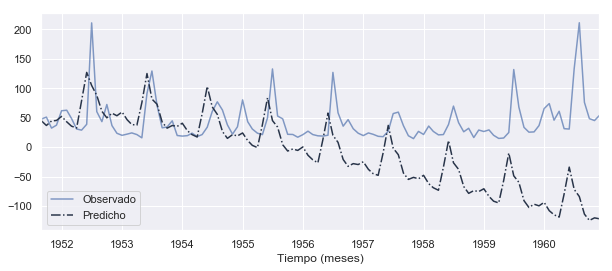

In [238]:
forecast_plot(test, knn_seas_forecast)
plt.show()

##### Regresion tree

In [239]:
depths = list(np.arange(1, 21, 1))

In [240]:
best_score, best_tree = float("inf"), None

for depth in depths:    
        tree = DecisionTreeRegressor(max_depth=depth, random_state=seed)
        
        tree_model1 = tree.fit(X_train1, y_train1)
        tree_forecast = iter_forecast(tree_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], tree_forecast))
        
        tree_model2 = tree.fit(X_val1, y_val1)
        tree_forecast = iter_forecast(tree_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], tree_forecast))
        
        tree_model3 = tree.fit(X_val2, y_val2)
        tree_forecast = iter_forecast(tree_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], tree_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
        if cvrmse < best_score:
            best_score, best_tree = cvrmse, tree.get_params()
        
print('Best Tree %s CV RMSE = %.3f' % (best_tree['max_depth'], best_score))

Best Tree 1 CV RMSE = 26.466


In [241]:
tree_hyp = {"depth": 1}

In [242]:
tree = DecisionTreeRegressor(max_depth=tree_hyp["depth"], 
                             random_state=seed)
tree_model = tree.fit(X_train, y_train)
tree_fitted = pd.Series(tree_model.predict(X_train))
tree_fitted
tree_fitted.index = X_train.index
tree_resid = y_train - tree_fitted
tree_resid = (tree_resid - tree_resid.mean()) / tree_resid.std()

tree_jb_test = jb(tree_resid)
tree_lb_test = lb(tree_resid)

tree_forecast = iter_forecast(tree, y_train, 12, test)

In [243]:
tree_undiff_forecast = []
last_obser = deseas.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + tree_forecast[i]
    tree_undiff_forecast.append(yhat)
    last_obser = yhat
    
tree_undiff_forecast = pd.Series(tree_undiff_forecast)
tree_undiff_forecast.index = test.index

In [244]:
tree_seas_forecast = tree_undiff_forecast + seasonality_forecast

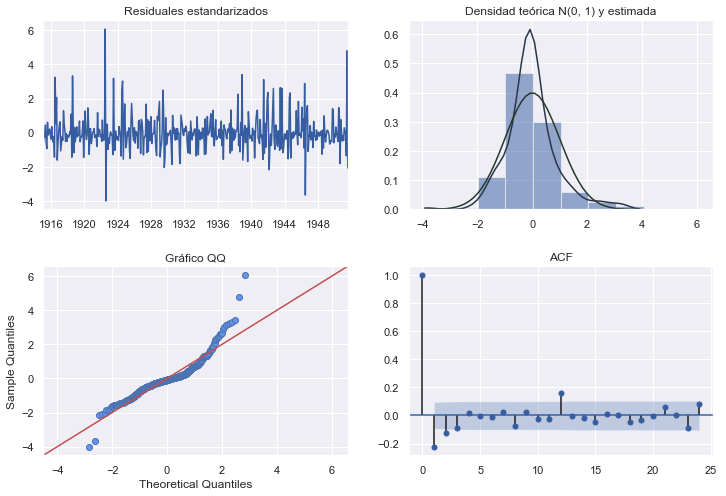

In [245]:
resid_diag(tree_resid)
plt.show()

In [246]:
print("Decision Tree")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(tree_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(tree_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(tree_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, tree_seas_forecast))))
print("MAE (test):  " + str(mae(test, tree_seas_forecast)))
print("sMAPE (test):  " + str(smape(test, tree_seas_forecast)))

Decision Tree

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 5.984587735691505e-150
Test de Ljung-Box para k =  6 (p-valor): 3.310821158172319e-05
Test de Ljung-Box para k = 12 (p-valor): 7.717590622639042e-06

RMSE (test): 220.1524782212875
MAE (test):  192.52545166614178
sMAPE (test):  130.60223449593917


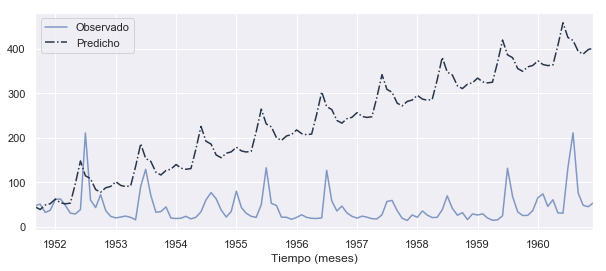

In [247]:
forecast_plot(test, tree_seas_forecast)
plt.show()

##### Random Forest

In [248]:
best_score, best_tree = float("inf"), None

n_estimators = [50, 100, 200, 500]
depths = np.linspace(1, 61, 20)
max_features = [0.8, 1]


for n in n_estimators:
    for depth in depths:
        for features in max_features:
            rf = RandomForestRegressor(n_estimators=n,
                                       max_depth=depth,
                                       max_features=features,
                                       random_state=seed)
        
            rf_model1 = rf.fit(X_train1, y_train1)
            rf_forecast = iter_forecast(rf_model1, y_train1, 12, validation1)
            rmse1 = sqrt(mse(validation1.iloc[:,-1], rf_forecast))
        
            rf_model2 = rf.fit(X_val1, y_val1)
            rf_forecast = iter_forecast(rf_model2, y_val1, 12, validation2)
            rmse2 = sqrt(mse(validation2.iloc[:,-1], rf_forecast))
        
            rf_model3 = rf.fit(X_val2, y_val2)
            rf_forecast = iter_forecast(rf_model3, y_val2, 12, validation3)
            rmse3 = sqrt(mse(validation3.iloc[:,-1], rf_forecast))
        
            cvrmse = mean([rmse1, rmse2, rmse3])        
            if cvrmse < best_score:
                best_score, best_rf = cvrmse, rf.get_params()
        
print('Best RF: n_estimators: %s max_depth: %s max_features :%s | CV RMSE = %.3f' % 
      (best_rf['n_estimators'], best_rf['max_depth'], best_rf['max_features'], best_score))

Best RF: n_estimators: 500 max_depth: 1.0 max_features :1 | CV RMSE = 25.879


In [249]:
rf_hyp = {"max_depth": 1,
          "n_estimators": 500,
          "max_features": 1}

In [250]:
rf = RandomForestRegressor(max_depth=rf_hyp["max_depth"],
                           n_estimators=rf_hyp["n_estimators"],
                           max_features=rf_hyp["max_features"],
                           random_state=seed)
rf_model = rf.fit(X_train, y_train)
rf_fitted = pd.Series(rf_model.predict(X_train))
rf_fitted
rf_fitted.index = X_train.index
rf_resid = y_train - rf_fitted
rf_resid = (rf_resid - rf_resid.mean()) / rf_resid.std()

rf_jb_test = jb(rf_resid)
rf_lb_test = lb(rf_resid)

rf_forecast = iter_forecast(rf, y_train, 12, test)

In [251]:
rf_undiff_forecast = []
last_obser = deseas.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + rf_forecast[i]
    rf_undiff_forecast.append(yhat)
    last_obser = yhat
    
rf_undiff_forecast = pd.Series(rf_undiff_forecast)
rf_undiff_forecast.index = test.index

In [252]:
rf_seas_forecast = rf_undiff_forecast + seasonality_forecast

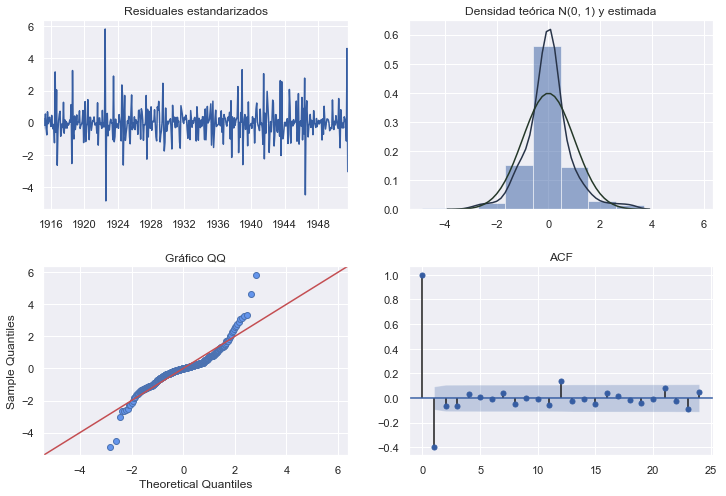

In [253]:
resid_diag(rf_resid)
plt.show()

In [254]:
print("Random Forest")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(rf_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(rf_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " + 
      str(rf_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, rf_seas_forecast))))
print("MAE (test):  " + str(mae(test, rf_seas_forecast)))
print("sMAPE (test):  " + str(smape(test, rf_seas_forecast)))

Random Forest

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 1.236348856640542e-154
Test de Ljung-Box para k =  6 (p-valor): 2.0612833395810488e-13
Test de Ljung-Box para k = 12 (p-valor): 9.123411363294815e-13

RMSE (test): 39.87890461677487
MAE (test):  29.491078404147572
sMAPE (test):  56.01068915026782


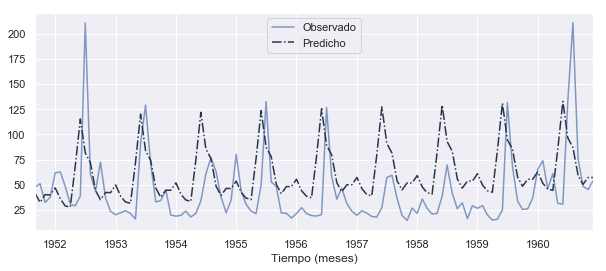

In [255]:
forecast_plot(test, rf_seas_forecast)
plt.show()

##### ElasticNet

In [256]:
best_score, best_tree = float("inf"), None

ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alpha = [0, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]


for rat in ratio:
    for alp in alpha:
        en = ElasticNet(l1_ratio=rat, alpha=alp, random_state=seed)
        
        en_model1 = en.fit(X_train1, y_train1)
        en_forecast = iter_forecast(en_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], en_forecast))
        
        en_model2 = en.fit(X_val1, y_val1)
        en_forecast = iter_forecast(en_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], en_forecast))
        
        en_model3 = en.fit(X_val2, y_val2)
        en_forecast = iter_forecast(en_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], en_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
        if cvrmse < best_score:
            best_score, best_en = cvrmse, en.get_params()
        
print('Best EN: ratio: %s alpha: %s | CV RMSE = %.3f' %
      (best_en['l1_ratio'], best_en['alpha'], best_score))

Best EN: ratio: 0.1 alpha: 0 | CV RMSE = 25.778


In [257]:
en_hyp = {"l1_ratio": 0.1,
          "alpha": 0}

In [258]:
en = ElasticNet(l1_ratio=en_hyp["l1_ratio"], alpha=en_hyp["alpha"],
                random_state=seed)
en_model = en.fit(X_train, y_train)
en_fitted = pd.Series(en_model.predict(X_train))
en_fitted
en_fitted.index = X_train.index
en_resid = y_train - en_fitted
en_resid = (en_resid - en_resid.mean()) / en_resid.std()

en_jb_test = jb(en_resid)
en_lb_test = lb(en_resid)

en_forecast = iter_forecast(en, y_train, 12, test)

In [259]:
en_undiff_forecast = []
last_obser = deseas.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + en_forecast[i]
    en_undiff_forecast.append(yhat)
    last_obser = yhat
    
en_undiff_forecast = pd.Series(en_undiff_forecast)
en_undiff_forecast.index = test.index

In [260]:
en_seas_forecast = en_undiff_forecast + seasonality_forecast

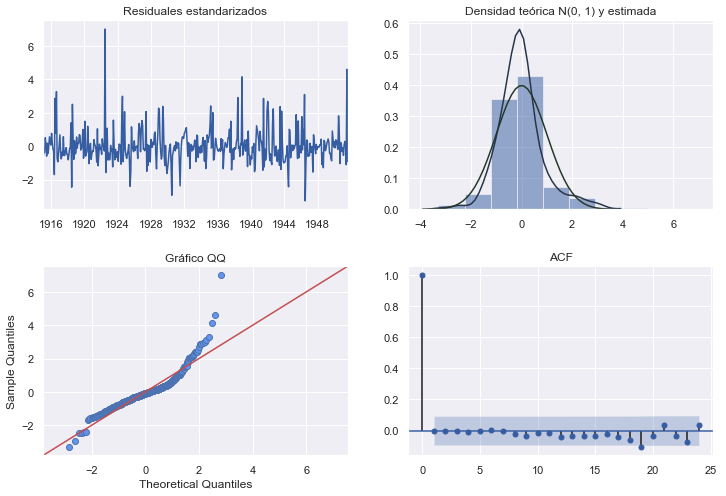

In [261]:
resid_diag(en_resid)
plt.show()

In [262]:
print("ElasticNet")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(en_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(en_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(en_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, en_seas_forecast))))
print("MAE (test):  " + str(mae(test, en_seas_forecast)))
print("sMAPE (test):  " + str(smape(test, en_seas_forecast)))

ElasticNet

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 2.0755161120405965e-264
Test de Ljung-Box para k =  6 (p-valor): 0.9999999468181409
Test de Ljung-Box para k = 12 (p-valor): 0.9994838286140066

RMSE (test): 35.74647450822158
MAE (test):  24.364237928781076
sMAPE (test):  47.541746791674875


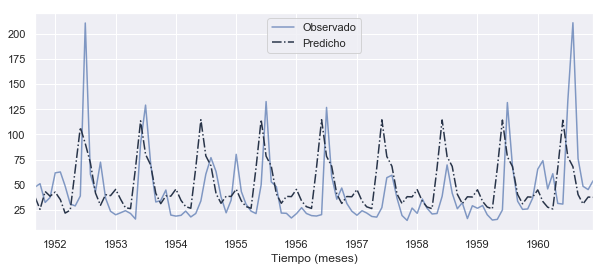

In [263]:
forecast_plot(test, en_seas_forecast)
plt.show()

#### Serie temporal con Box-Cox, desestacionalizada y diferenciada como estructura de DataFrame

In [264]:
lag_df = series_to_supervised(bc_diff_deseas, n_in=12)
lag_df.head(5)

var1(t-12)  var1(t-11)  var1(t-10)  var1(t-9)  var1(t-8)  \
index                                                                  
1915-02-01   -0.072518    0.026679   -0.076088  -0.037124  -0.075538   
1915-03-01    0.026679   -0.076088   -0.037124  -0.075538   0.024702   
1915-04-01   -0.076088   -0.037124   -0.075538   0.024702   0.113124   
1915-05-01   -0.037124   -0.075538    0.024702   0.113124   0.096046   
1915-06-01   -0.075538    0.024702    0.113124   0.096046  -0.009864   

            var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
index                                                                          
1915-02-01   0.024702   0.113124   0.096046  -0.009864  -0.041726   0.047586   
1915-03-01   0.113124   0.096046  -0.009864  -0.041726   0.047586  -0.059635   
1915-04-01   0.096046  -0.009864  -0.041726   0.047586  -0.059635  -0.076563   
1915-05-01  -0.009864  -0.041726   0.047586  -0.059635  -0.076563   0.022506   
1915-06-01  -0.041726   0.047586  -0.059635  -0.076563   0.022506  -0.051959   

            var1(t-1)   var1(t)  
index                            
1915-02-01  -0.059635 -0.076563  
1915-03-01  -0.076563  0.022506  
1915-04-01   0.022506 -0.051959  
1915-05-01  -0.051959  0.137671  
1915-06-01   0.137671 -0.061183

#### Definición de X (predictoras) e y (a predecir)

In [265]:
X_train = lag_df.iloc[:,:-1]
y_train = lag_df.iloc[:,-1]

#### Validación cruzada temporal

In [266]:
train3, validation3 = ts_split(lag_df, train_size=0.75)
X_train3 = train3.iloc[:,:-1]
y_train3 = train3.iloc[:,-1]
X_val3 = validation3.iloc[:,:-1]
y_val3 = validation3.iloc[:,-1]

train2, validation2 = ts_split(train3, train_size=0.66)
X_train2 = train2.iloc[:,:-1]
y_train2 = train2.iloc[:,-1]
X_val2 = validation2.iloc[:,:-1]
y_val2 = validation2.iloc[:,-1]

train1, validation1 = ts_split(train2, train_size=0.5)
X_train1 = train1.iloc[:,:-1]
y_train1 = train1.iloc[:,-1]
X_val1 = validation1.iloc[:,:-1]
y_val1 = validation1.iloc[:,-1]

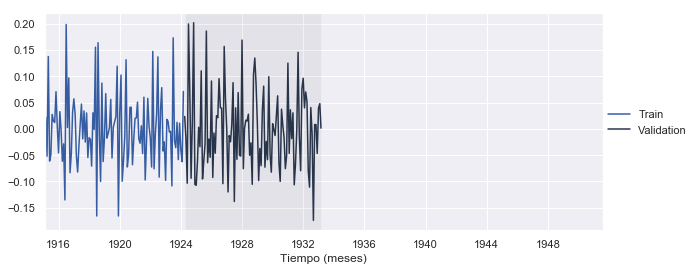

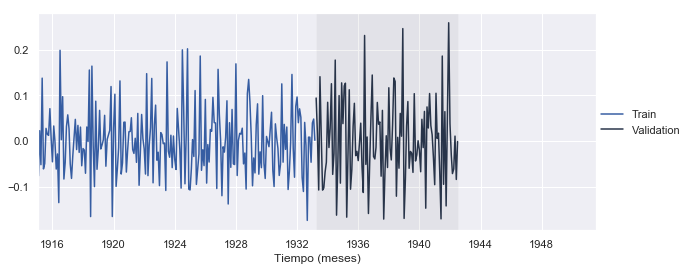

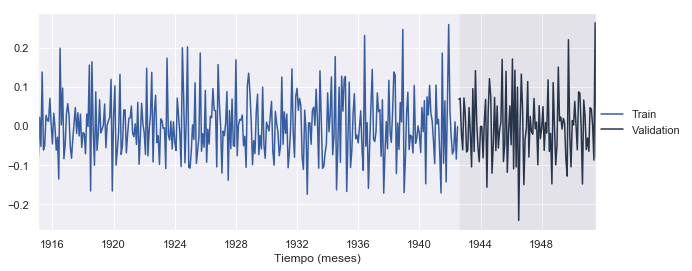

In [267]:
tscv_plot(train1["var1(t)"], validation1["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train2["var1(t)"], validation2["var1(t)"], train.index[-1])
plt.show()
tscv_plot(train3["var1(t)"], validation3["var1(t)"], train.index[-1])
plt.show()

##### K-Nearest Neighbors 

In [268]:
neigb = list(np.arange(2, 41, 1))

In [269]:
best_score, best_knn = float("inf"), None

for k in neigb:    
        knn = KNeighborsRegressor(n_neighbors=k)
        
        knn_model1 = knn.fit(X_train1, y_train1)
        knn_forecast = iter_forecast(knn_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], knn_forecast))
        
        knn_model2 = knn.fit(X_val1, y_val1)
        knn_forecast = iter_forecast(knn_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], knn_forecast))
        
        knn_model3 = knn.fit(X_val2, y_val2)
        knn_forecast = iter_forecast(knn_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], knn_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])        
        if cvrmse < best_score:
            best_score, best_knn = cvrmse, knn.get_params()
        
print('Best KNN %s CVRMSE = %.3f' % (best_knn['n_neighbors'], best_score))

Best KNN 27 CVRMSE = 0.084


In [270]:
knn_hyp = {"k": 27}

In [271]:
knn = KNeighborsRegressor(n_neighbors=knn_hyp["k"])
knn_model = knn.fit(X_train, y_train)
knn_fitted = pd.Series(knn_model.predict(X_train))
knn_fitted
knn_fitted.index = X_train.index
knn_resid = y_train - knn_fitted
knn_resid = (knn_resid - knn_resid.mean()) / knn_resid.std()

knn_jb_test = jb(knn_resid)
knn_lb_test = lb(knn_resid)

knn_forecast = iter_forecast(knn, y_train, 12, test)

In [272]:
knn_undiff_forecast = []
last_obser = bc_deseas.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + knn_forecast[i]
    knn_undiff_forecast.append(yhat)
    last_obser = yhat
    
knn_undiff_forecast = pd.Series(knn_undiff_forecast)
knn_undiff_forecast.index = test.index

In [273]:
knn_seas_forecast = knn_undiff_forecast + bc_seasonality_forecast
knn_box_forecast = (bc_param * knn_seas_forecast + 1) ** (1 / bc_param)

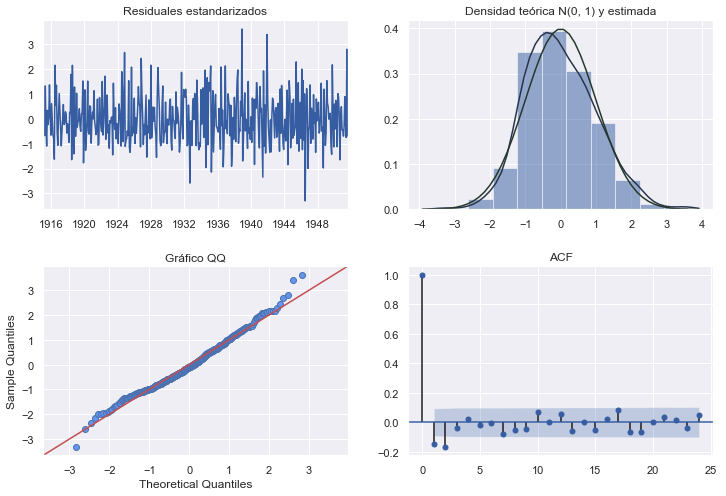

In [274]:
resid_diag(knn_resid)
plt.show()

In [275]:
print("K-Nearest Neighbors")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(knn_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(knn_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(knn_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, knn_box_forecast))))
print("MAE (test):  " + str(mae(test, knn_box_forecast)))
print("sMAPE (test):  " + str(smape(test, knn_box_forecast)))

K-Nearest Neighbors

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 0.003383083593474169
Test de Ljung-Box para k =  6 (p-valor): 0.0005375519245986289
Test de Ljung-Box para k = 12 (p-valor): 0.0015617704092770694

RMSE (test): 36.49420211710823
MAE (test):  22.4493403519271
sMAPE (test):  52.483487500997285


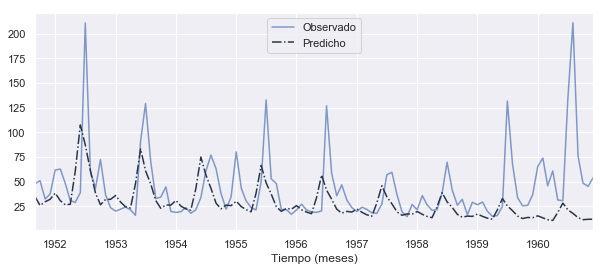

In [276]:
forecast_plot(test, knn_box_forecast)
plt.show()

##### Regresion tree

In [277]:
depths = list(np.arange(1, 21, 1))

In [278]:
best_score, best_tree = float("inf"), None

for depth in depths:    
        tree = DecisionTreeRegressor(max_depth=depth, random_state=seed)
        
        tree_model1 = tree.fit(X_train1, y_train1)
        tree_forecast = iter_forecast(tree_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], tree_forecast))
        
        tree_model2 = tree.fit(X_val1, y_val1)
        tree_forecast = iter_forecast(tree_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], tree_forecast))
        
        tree_model3 = tree.fit(X_val2, y_val2)
        tree_forecast = iter_forecast(tree_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], tree_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
        if cvrmse < best_score:
            best_score, best_tree = cvrmse, tree.get_params()
        
print('Best Tree %s CV RMSE = %.3f' % (best_tree['max_depth'], best_score))

Best Tree 1 CV RMSE = 0.088


In [279]:
tree_hyp = {"depth": 1}

In [280]:
tree = DecisionTreeRegressor(max_depth=tree_hyp["depth"],
                             random_state=seed)
tree_model = tree.fit(X_train, y_train)
tree_fitted = pd.Series(tree_model.predict(X_train))
tree_fitted
tree_fitted.index = X_train.index
tree_resid = y_train - tree_fitted
tree_resid = (tree_resid - tree_resid.mean()) / tree_resid.std()

tree_jb_test = jb(tree_resid)
tree_lb_test = lb(tree_resid)

tree_forecast = iter_forecast(tree, y_train, 12, test)

In [281]:
tree_undiff_forecast = []
last_obser = bc_deseas.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + tree_forecast[i]
    tree_undiff_forecast.append(yhat)
    last_obser = yhat
    
tree_undiff_forecast = pd.Series(tree_undiff_forecast)
tree_undiff_forecast.index = test.index

In [282]:
tree_seas_forecast = knn_undiff_forecast + bc_seasonality_forecast
tree_box_forecast = (bc_param * tree_seas_forecast + 1) ** (1 / bc_param)

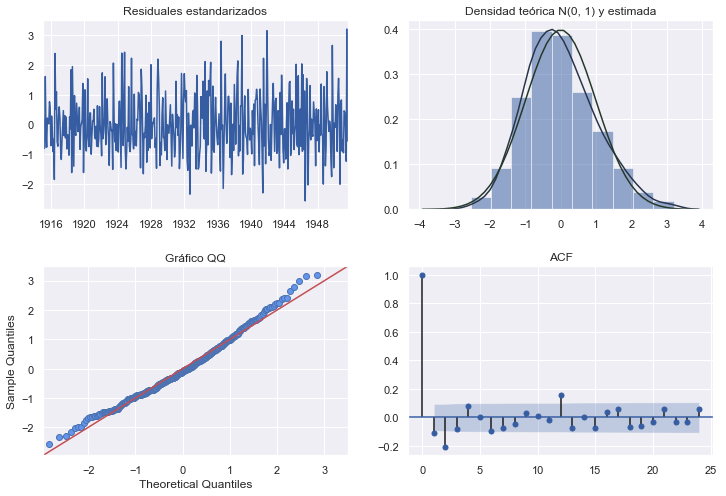

In [283]:
resid_diag(tree_resid)
plt.show()

In [284]:
print("Decision Tree")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(tree_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(tree_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " + 
      str(tree_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, tree_box_forecast))))
print("MAE (test):  " + str(mae(test, tree_box_forecast)))
print("sMAPE (test):  " + str(smape(test, tree_box_forecast)))

Decision Tree

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 0.0010506447401931551
Test de Ljung-Box para k =  6 (p-valor): 7.73151312209853e-06
Test de Ljung-Box para k = 12 (p-valor): 1.3985418477241946e-06

RMSE (test): 36.49420211710823
MAE (test):  22.4493403519271
sMAPE (test):  52.483487500997285


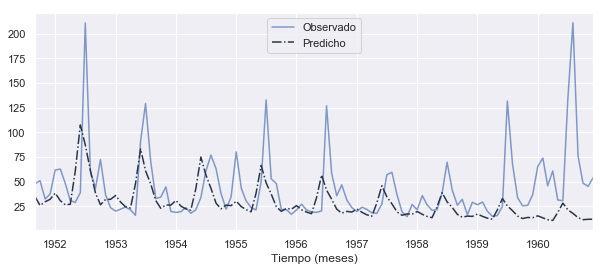

In [285]:
forecast_plot(test, tree_box_forecast)
plt.show()

##### Random Forest

In [286]:
best_score, best_tree = float("inf"), None

n_estimators = [50, 100, 200, 500]
depths = np.linspace(1, 61, 20)
max_features = [0.8, 1]


for n in n_estimators:
    for depth in depths:
        for features in max_features:
            rf = RandomForestRegressor(n_estimators=n,
                                       max_depth=depth,
                                       max_features=features,
                                       random_state=seed)
        
            rf_model1 = rf.fit(X_train1, y_train1)
            rf_forecast = iter_forecast(rf_model1, y_train1, 12, validation1)
            rmse1 = sqrt(mse(validation1.iloc[:,-1], rf_forecast))
        
            rf_model2 = rf.fit(X_val1, y_val1)
            rf_forecast = iter_forecast(rf_model2, y_val1, 12, validation2)
            rmse2 = sqrt(mse(validation2.iloc[:,-1], rf_forecast))
        
            rf_model3 = rf.fit(X_val2, y_val2)
            rf_forecast = iter_forecast(rf_model3, y_val2, 12, validation3)
            rmse3 = sqrt(mse(validation3.iloc[:,-1], rf_forecast))
        
            cvrmse = mean([rmse1, rmse2, rmse3])        
            if cvrmse < best_score:
                best_score, best_rf = cvrmse, rf.get_params()
        
print('Best RF: n_estimators: %s max_depth: %s max_features :%s | CV RMSE = %.3f' % 
      (best_rf['n_estimators'], best_rf['max_depth'], best_rf['max_features'], best_score))

Best RF: n_estimators: 200 max_depth: 10.473684210526315 max_features :1 | CV RMSE = 0.085


In [287]:
rf_hyp = {"max_depth": 10.47,
          "n_estimators": 200,
          "max_features": 1}

In [288]:
rf = RandomForestRegressor(max_depth=rf_hyp["max_depth"],
                           n_estimators=rf_hyp["n_estimators"],
                           max_features=rf_hyp["max_features"],
                           random_state=seed)

rf_model = rf.fit(X_train, y_train)
rf_fitted = pd.Series(rf_model.predict(X_train))
rf_fitted
rf_fitted.index = X_train.index
rf_resid = y_train - rf_fitted
rf_resid = (rf_resid - rf_resid.mean()) / rf_resid.std()

rf_jb_test = jb(rf_resid)
rf_lb_test = lb(rf_resid)

rf_forecast = iter_forecast(rf, y_train, 12, test)

In [289]:
rf_undiff_forecast = []
last_obser = bc_deseas.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + rf_forecast[i]
    rf_undiff_forecast.append(yhat)
    last_obser = yhat
    
rf_undiff_forecast = pd.Series(rf_undiff_forecast)
rf_undiff_forecast.index = test.index

In [290]:
rf_seas_forecast = rf_undiff_forecast + bc_seasonality_forecast
rf_box_forecast = (bc_param * rf_seas_forecast + 1) ** (1 / bc_param)

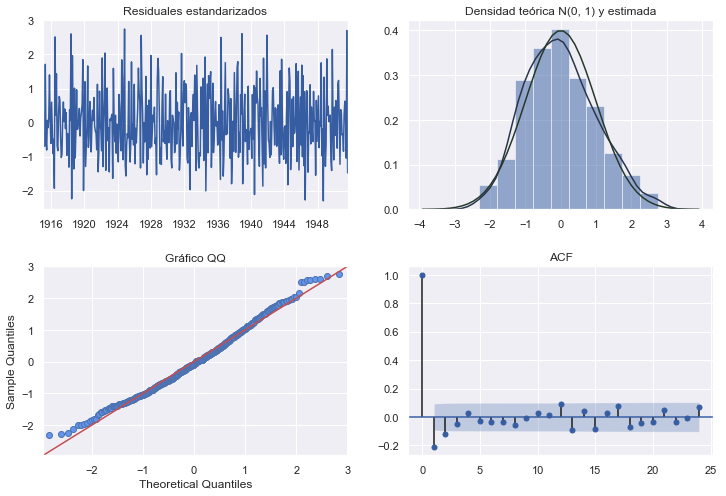

In [291]:
resid_diag(rf_resid)
plt.show()

In [292]:
print("Random Forest")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(rf_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " +
      str(rf_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(rf_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, rf_box_forecast))))
print("MAE (test):  " + str(mae(test, rf_box_forecast)))
print("sMAPE (test):  " + str(smape(test, rf_box_forecast)))

Random Forest

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 0.011941226814951477
Test de Ljung-Box para k =  6 (p-valor): 0.00015047040565678517
Test de Ljung-Box para k = 12 (p-valor): 0.0002746332719588352

RMSE (test): 33.32998445529877
MAE (test):  20.927560058562502
sMAPE (test):  43.07766738416892


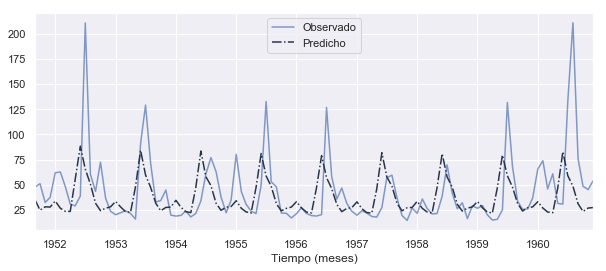

In [293]:
forecast_plot(test, rf_box_forecast)
plt.show()

##### ElasticNet

In [294]:
best_score, best_tree = float("inf"), None

ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alpha = [0, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]


for rat in ratio:
    for alp in alpha:
        en = ElasticNet(l1_ratio=rat, alpha=alp, random_state=seed)
        
        en_model1 = en.fit(X_train1, y_train1)
        en_forecast = iter_forecast(en_model1, y_train1, 12, validation1)
        rmse1 = sqrt(mse(validation1.iloc[:,-1], en_forecast))
        
        en_model2 = en.fit(X_val1, y_val1)
        en_forecast = iter_forecast(en_model2, y_val1, 12, validation2)
        rmse2 = sqrt(mse(validation2.iloc[:,-1], en_forecast))
        
        en_model3 = en.fit(X_val2, y_val2)
        en_forecast = iter_forecast(en_model3, y_val2, 12, validation3)
        rmse3 = sqrt(mse(validation3.iloc[:,-1], en_forecast))
        
        cvrmse = mean([rmse1, rmse2, rmse3])
        if cvrmse < best_score:
            best_score, best_en = cvrmse, en.get_params()
        
print('Best EN: ratio: %s alpha: %s | CV RMSE = %.3f' %
      (best_en['l1_ratio'], best_en['alpha'], best_score))

Best EN: ratio: 0.1 alpha: 0.1 | CV RMSE = 0.085


In [295]:
en_hyp = {"l1_ratio": 0.1,
          "alpha": 0.1}

In [296]:
en = ElasticNet(l1_ratio=en_hyp["l1_ratio"], alpha=en_hyp["alpha"], 
                random_state=seed)
en_model = en.fit(X_train, y_train)
en_fitted = pd.Series(en_model.predict(X_train))
en_fitted
en_fitted.index = X_train.index
en_resid = y_train - en_fitted
en_resid = (en_resid - en_resid.mean()) / en_resid.std()

en_jb_test = jb(en_resid)
en_lb_test = lb(en_resid)

en_forecast = iter_forecast(en, y_train, 12, test)

In [297]:
en_undiff_forecast = []
last_obser = bc_deseas.iloc[-1].value
for i in range(len(test)):
    yhat = last_obser + en_forecast[i]
    en_undiff_forecast.append(yhat)
    last_obser = yhat
    
en_undiff_forecast = pd.Series(en_undiff_forecast)
en_undiff_forecast.index = test.index

In [298]:
en_seas_forecast = en_undiff_forecast + bc_seasonality_forecast
en_box_forecast = (bc_param * en_seas_forecast + 1) ** (1 / bc_param)

In [299]:
en_box_forecast = (bc_param * en_seas_forecast + 1) ** (1 / bc_param)

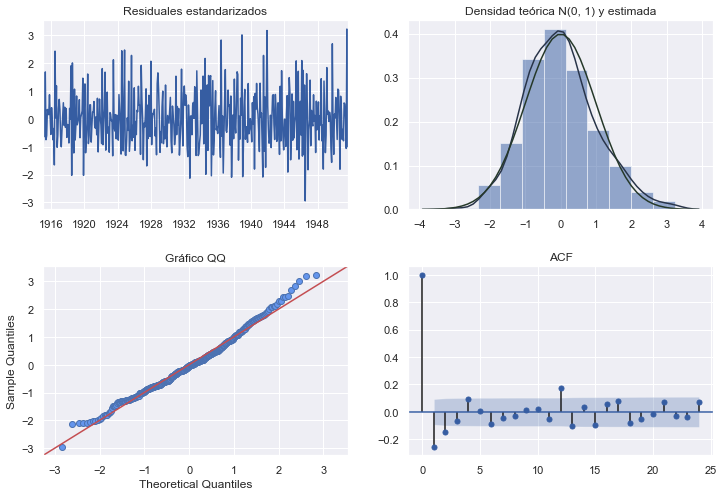

In [300]:
resid_diag(en_resid)
plt.show()

In [301]:
print("ElasticNet")
print("")
print("Observaciones ajustadas: " + str(len(train)))
print("Observaciones predichas: " + str(len(test)))
print("")
print("Test de Jarque-Bera (p-valor): " + str(en_jb_test[1]))
print("Test de Ljung-Box para k =  6 (p-valor): " + 
      str(en_lb_test[1][6]))
print("Test de Ljung-Box para k = 12 (p-valor): " +
      str(en_lb_test[1][12]))
print("")
print("RMSE (test): " + str(sqrt(mse(test, en_box_forecast))))
print("MAE (test):  " + str(mae(test, en_box_forecast)))
print("sMAPE (test):  " + str(smape(test, en_box_forecast)))

ElasticNet

Observaciones ajustadas: 452
Observaciones predichas: 112

Test de Jarque-Bera (p-valor): 0.001788964092508347
Test de Ljung-Box para k =  6 (p-valor): 2.3939918413298452e-08
Test de Ljung-Box para k = 12 (p-valor): 1.0498455598897642e-09

RMSE (test): 35.28368401389798
MAE (test):  23.133149094283
sMAPE (test):  45.15517516895144


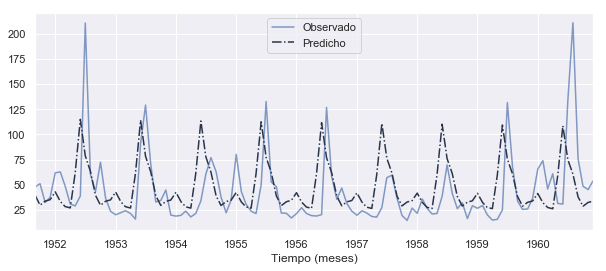

In [302]:
forecast_plot(test, en_box_forecast)
plt.show()